# Churn Data Science Project

Author: Darren Singh     
Dataset Credit: Delina Ivanova

In [12]:
# imports 
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, precision_recall_curve, precision_score, roc_auc_score, roc_curve, accuracy_score, mean_squared_error, confusion_matrix, classification_report
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.ensemble import RandomForestClassifier

In [13]:
# read in data
data = pd.read_csv("churn_data.csv")
data.head()

,Unnamed: 0,CustomerID,Age,Location,Device,Month_1_Spend,Month_1_Items,Month_1_Support_Calls,Month_2_Spend,Month_2_Items,...,Month_10_Spend,Month_10_Items,Month_10_Support_Calls,Month_11_Spend,Month_11_Items,Month_11_Support_Calls,Month_12_Spend,Month_12_Items,Month_12_Support_Calls,Churn
0,0,1,46,US,iOS,756.005761,39,2,582.023075,92,...,280.397827,60,0,700.181510,66,3,382.719682,59,0,1
1,1,2,52,US,iOS,594.838157,59,0,251.269898,33,...,863.000645,89,1,571.331352,28,3,570.203975,89,0,1
2,2,3,43,Canada,Android,453.217405,21,3,124.178946,92,...,858.545990,60,5,198.222684,38,1,187.475764,79,5,1
3,3,4,41,US,iOS,621.453170,95,1,134.362559,46,...,404.590146,59,3,565.395592,78,1,281.415092,63,4,1
4,4,5,41,US,iOS,660.735119,48,5,713.265527,54,...,178.143438,85,1,574.382094,34,2,544.981985,28,2,1


### Data Cleaning & Preparation

In [14]:
# the un-named column is a repeat of the index, we can drop it since we don't need it
# we already have customer ID that can be used as a unique identifier if need be
data.drop('Unnamed: 0', axis=1, inplace=True)

# verify change took effect
data.head()

,CustomerID,Age,Location,Device,Month_1_Spend,Month_1_Items,Month_1_Support_Calls,Month_2_Spend,Month_2_Items,Month_2_Support_Calls,...,Month_10_Spend,Month_10_Items,Month_10_Support_Calls,Month_11_Spend,Month_11_Items,Month_11_Support_Calls,Month_12_Spend,Month_12_Items,Month_12_Support_Calls,Churn
0,1,46,US,iOS,756.005761,39,2,582.023075,92,2,...,280.397827,60,0,700.181510,66,3,382.719682,59,0,1
1,2,52,US,iOS,594.838157,59,0,251.269898,33,2,...,863.000645,89,1,571.331352,28,3,570.203975,89,0,1
2,3,43,Canada,Android,453.217405,21,3,124.178946,92,0,...,858.545990,60,5,198.222684,38,1,187.475764,79,5,1
3,4,41,US,iOS,621.453170,95,1,134.362559,46,5,...,404.590146,59,3,565.395592,78,1,281.415092,63,4,1
4,5,41,US,iOS,660.735119,48,5,713.265527,54,2,...,178.143438,85,1,574.382094,34,2,544.981985,28,2,1


In [15]:
# begin by checking info() and describe()
data.info()

# no null values are present
# every column appears to be the correct data type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 41 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CustomerID              10000 non-null  int64  
 1   Age                     10000 non-null  int64  
 2   Location                10000 non-null  object 
 3   Device                  10000 non-null  object 
 4   Month_1_Spend           10000 non-null  float64
 5   Month_1_Items           10000 non-null  int64  
 6   Month_1_Support_Calls   10000 non-null  int64  
 7   Month_2_Spend           10000 non-null  float64
 8   Month_2_Items           10000 non-null  int64  
 9   Month_2_Support_Calls   10000 non-null  int64  
 10  Month_3_Spend           10000 non-null  float64
 11  Month_3_Items           10000 non-null  int64  
 12  Month_3_Support_Calls   10000 non-null  int64  
 13  Month_4_Spend           10000 non-null  float64
 14  Month_4_Items           10000 non-null 

In [16]:
# check descriptive statistics
data.describe(include='all')

# from this initial check there does not appear to be any anomalies in the data
# all the maximum values are within the expected range for each column
# potential outliers will be checked for in the upcoming univariate exploratory analysis

,CustomerID,Age,Location,Device,Month_1_Spend,Month_1_Items,Month_1_Support_Calls,Month_2_Spend,Month_2_Items,Month_2_Support_Calls,...,Month_10_Spend,Month_10_Items,Month_10_Support_Calls,Month_11_Spend,Month_11_Items,Month_11_Support_Calls,Month_12_Spend,Month_12_Items,Month_12_Support_Calls,Churn
count,10000.00000,10000.000000,10000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
unique,NaN,NaN,4,2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Canada,Android,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,4258,5736,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5000.50000,42.698500,NaN,NaN,482.593336,64.657700,2.488800,476.297118,63.118000,2.517400,...,473.630524,58.227900,2.487000,472.671126,56.968900,2.519500,478.629330,56.512600,2.496300,0.70000
std,2886.89568,12.495528,NaN,NaN,237.961476,29.329527,1.711306,237.491820,28.933247,1.703639,...,235.090366,25.909251,1.721083,234.288930,25.615119,1.702266,233.135282,25.263995,1.713674,0.45828
min,1.00000,20.000000,NaN,NaN,45.147050,12.000000,0.000000,46.283232,12.000000,0.000000,...,45.784922,12.000000,0.000000,45.139863,12.000000,0.000000,45.093583,12.000000,0.000000,0.00000
25%,2500.75000,32.000000,NaN,NaN,275.978779,39.000000,1.000000,268.427326,38.000000,1.000000,...,268.470286,36.000000,1.000000,269.432095,35.000000,1.000000,276.507055,35.000000,1.000000,0.00000
50%,5000.50000,43.000000,NaN,NaN,482.173250,65.000000,2.000000,474.442784,63.000000,3.000000,...,472.391691,58.000000,2.000000,472.530676,57.000000,3.000000,481.872558,56.000000,3.000000,1.00000
75%,7500.25000,53.000000,NaN,NaN,688.898992,90.000000,4.000000,680.824377,88.000000,4.000000,...,680.923305,80.000000,4.000000,673.599392,78.000000,4.000000,681.397961,77.000000,4.000000,1.00000


### Exploratory Analysis

Will begin with a univariate analysis and then move up towards a multivariate analysis.

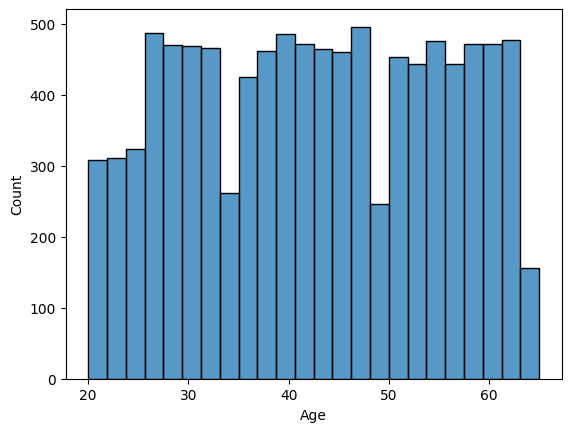

In [17]:
# begin with univariate analysis - check each variable on its own to locate potential outliers / trends

# start with age
sns.histplot(x=data['Age'])
plt.show()

# appears to be a slight imbalance among ages
# ages 20-25, 35, 49 and 65 have lower counts (<300) than the counts of the other ages (~500)

# at this point no action will be taken but it is something worth noting as it may impact certain models

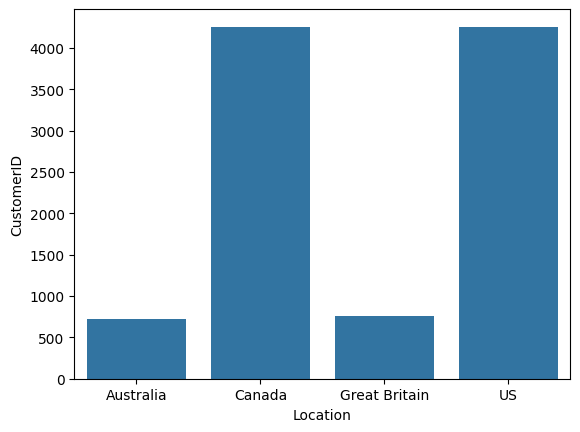

In [18]:
# next check location

# group data by location
loc = data.groupby('Location')

sns.barplot(x=loc['CustomerID'].count().index, y=loc['CustomerID'].count())
plt.show()

# there is a data imbalance present here, roughly 8 times more customers from US and CAN than AUS and Great Britain

# if models perform poorly, one could consider applying some type of normalization (or over sampling) to the data

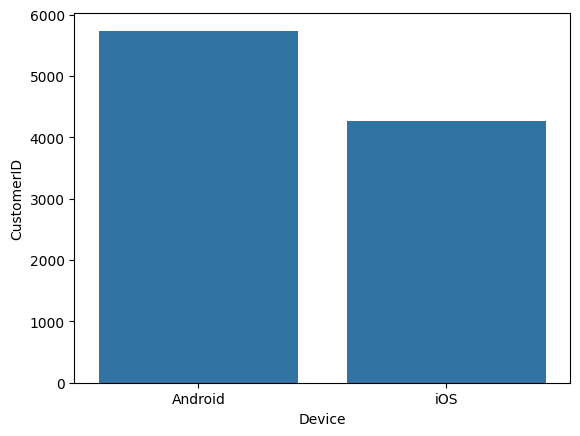

In [19]:
# next is device

# group data by device
dev = data.groupby('Device')

sns.barplot(x=dev['CustomerID'].count().index, y=dev['CustomerID'].count())
plt.show()

# slightly more users on Android, nothing else of interest to note

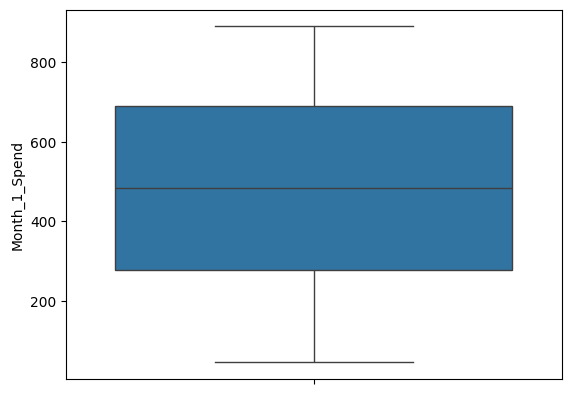

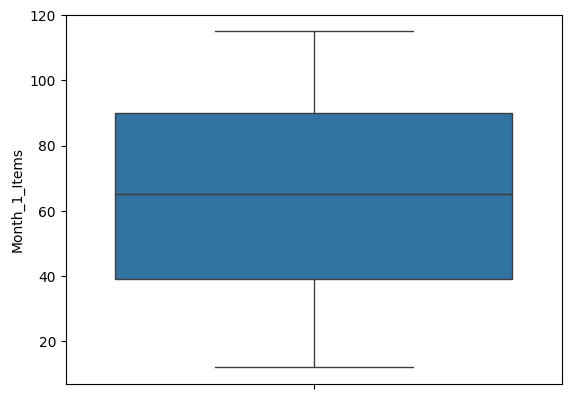

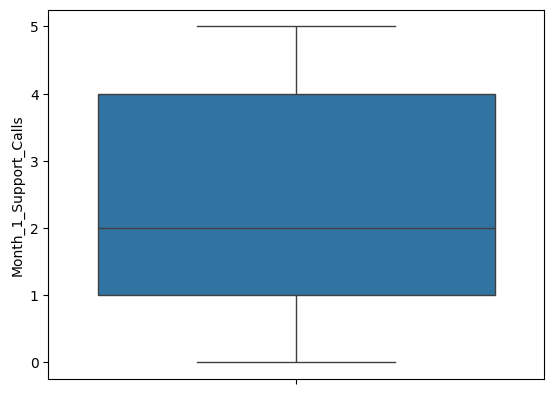

In [20]:
# univariate check month 1 quantities

sns.boxplot(data['Month_1_Spend'])
plt.show()
sns.boxplot(data['Month_1_Items'])
plt.show()
sns.boxplot(data['Month_1_Support_Calls'])
plt.show()

# nothing of interest to note

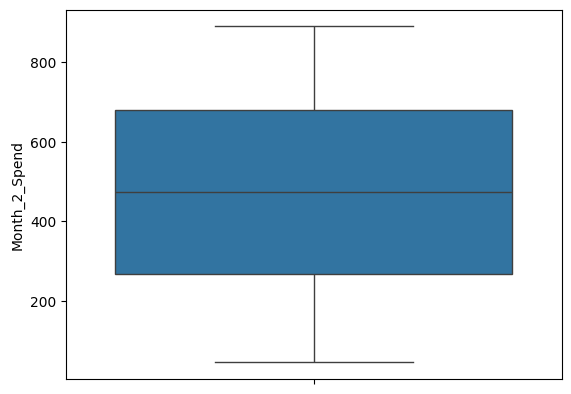

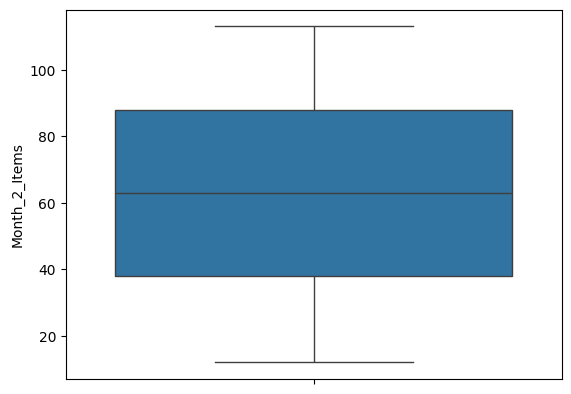

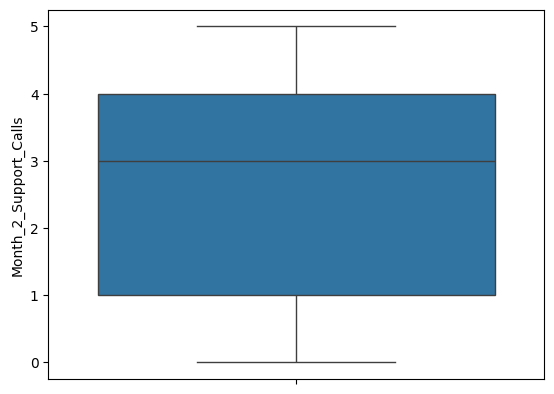

In [21]:
# univariate of month 2 quantities

sns.boxplot(data['Month_2_Spend'])
plt.show()
sns.boxplot(data['Month_2_Items'])
plt.show()
sns.boxplot(data['Month_2_Support_Calls'])
plt.show()

# nothing of interest to note here

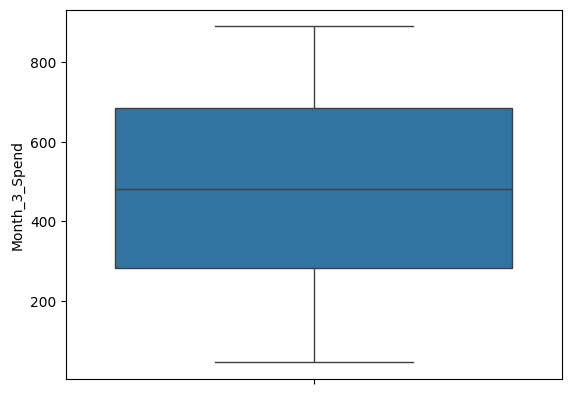

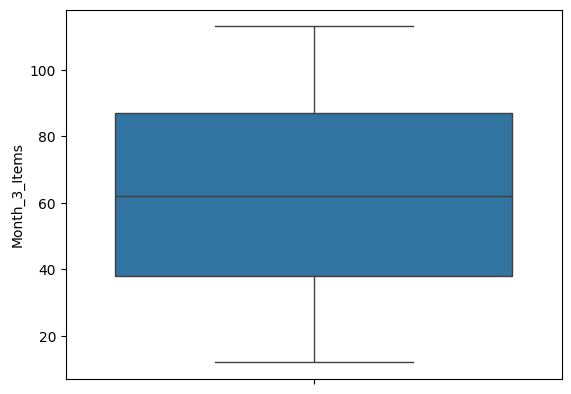

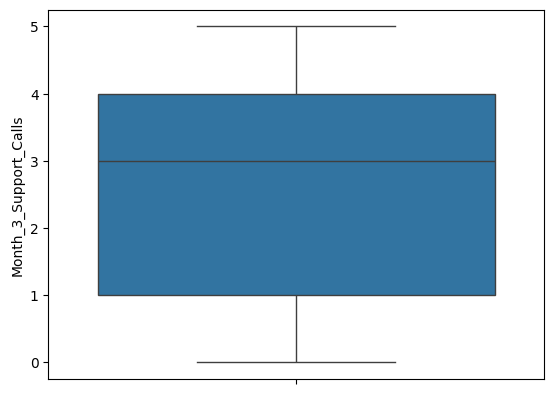

In [22]:
# univariate of month 3 quantities

sns.boxplot(data['Month_3_Spend'])
plt.show()
sns.boxplot(data['Month_3_Items'])
plt.show()
sns.boxplot(data['Month_3_Support_Calls'])
plt.show()

# nothing of interest to note here

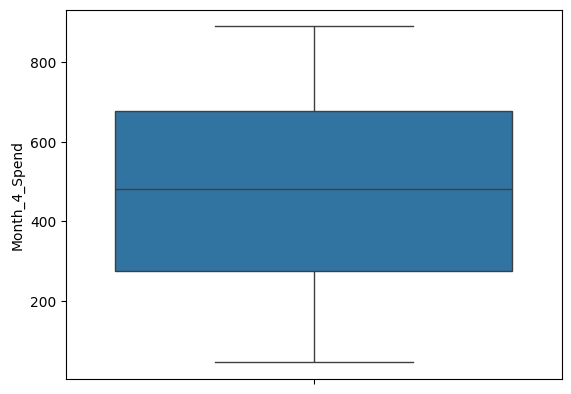

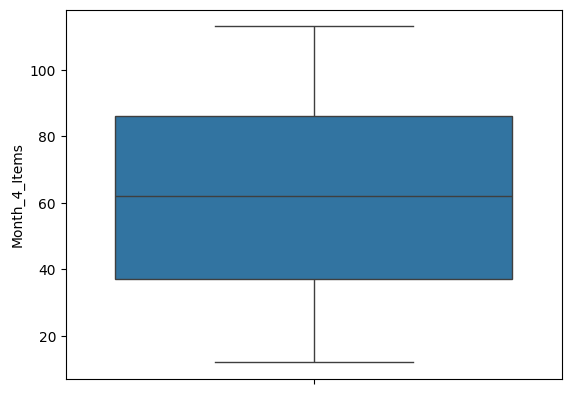

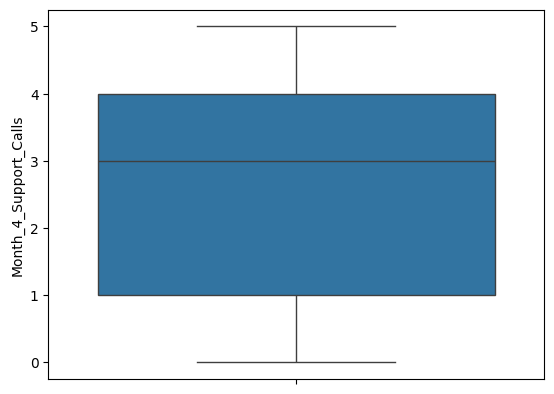

In [23]:
# univariate of month 4 quantities

sns.boxplot(data['Month_4_Spend'])
plt.show()
sns.boxplot(data['Month_4_Items'])
plt.show()
sns.boxplot(data['Month_4_Support_Calls'])
plt.show()

# nothing of interest to note here

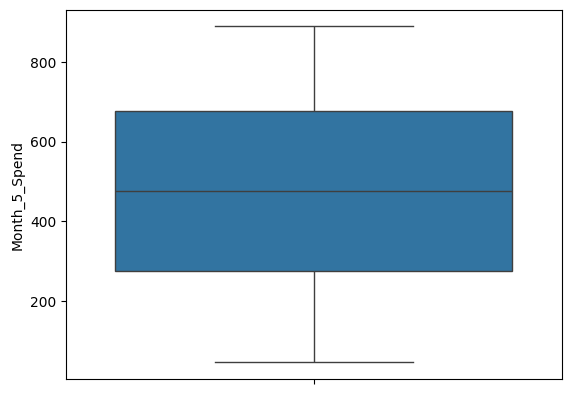

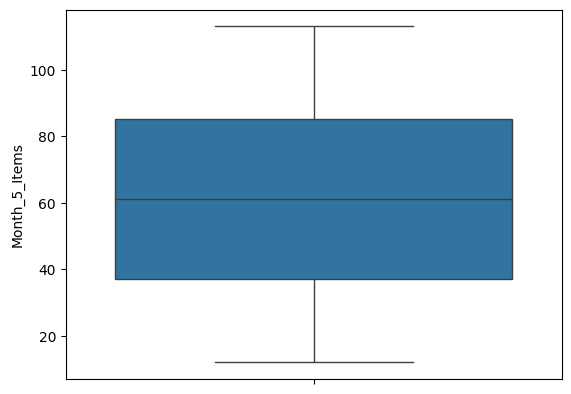

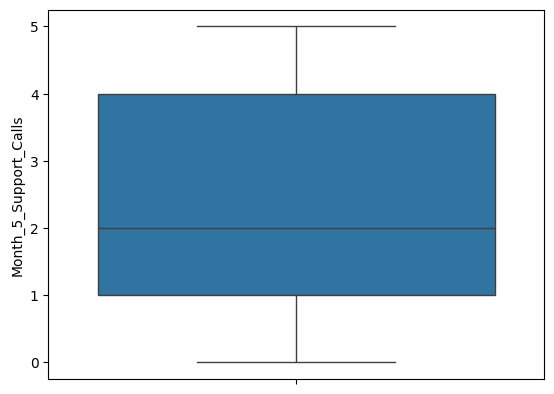

In [24]:
# univariate of month 5 quantities

sns.boxplot(data['Month_5_Spend'])
plt.show()
sns.boxplot(data['Month_5_Items'])
plt.show()
sns.boxplot(data['Month_5_Support_Calls'])
plt.show()

# nothing of interest to note here

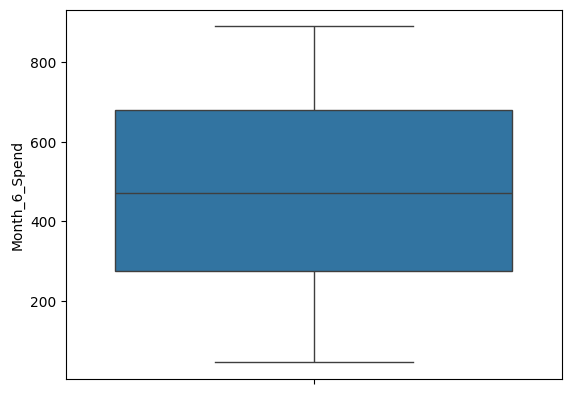

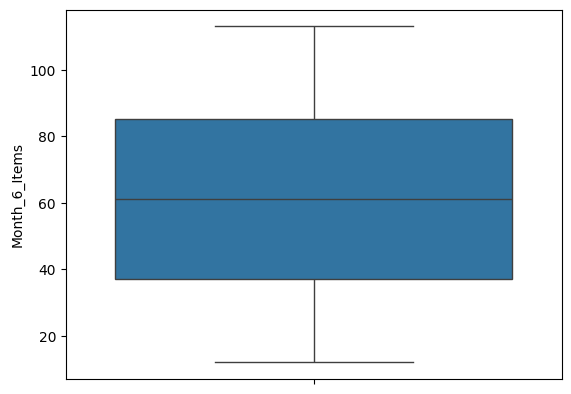

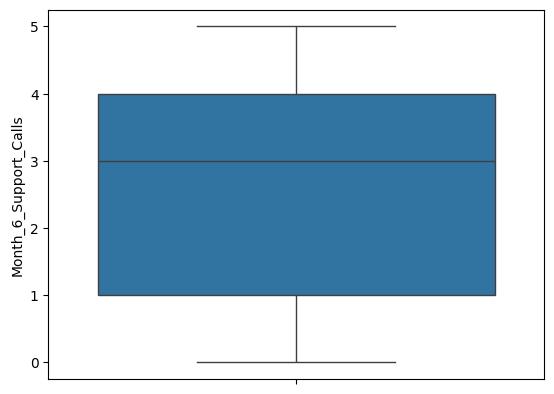

In [25]:
# univariate of month 6 quantities

sns.boxplot(data['Month_6_Spend'])
plt.show()
sns.boxplot(data['Month_6_Items'])
plt.show()
sns.boxplot(data['Month_6_Support_Calls'])
plt.show()

# nothing of interest to note here

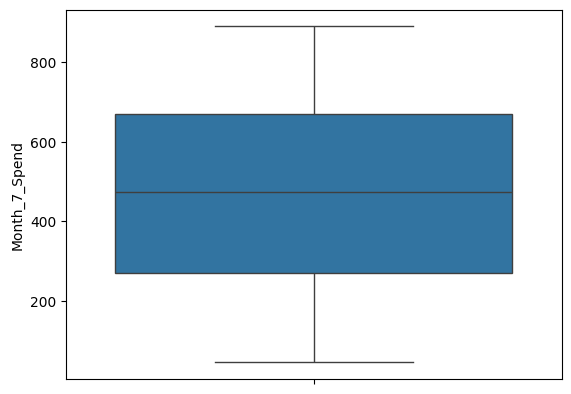

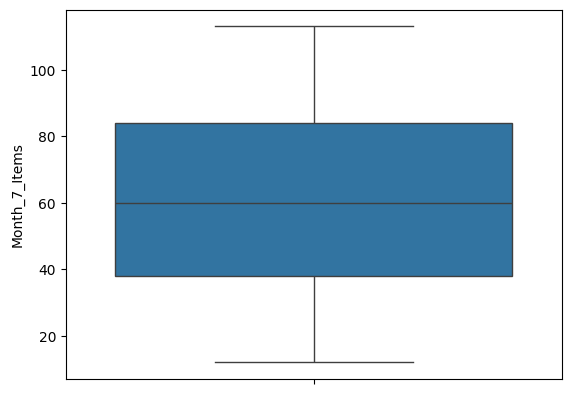

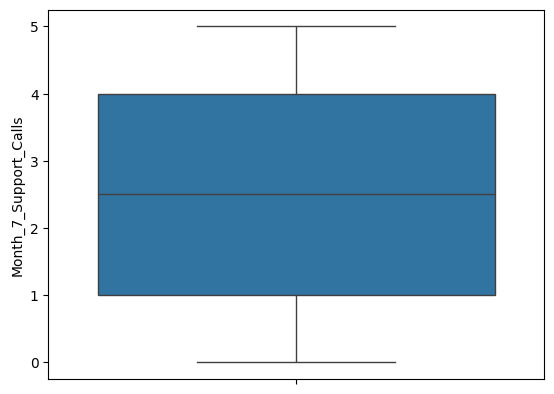

In [26]:
# univariate of month 7 quantities

sns.boxplot(data['Month_7_Spend'])
plt.show()
sns.boxplot(data['Month_7_Items'])
plt.show()
sns.boxplot(data['Month_7_Support_Calls'])
plt.show()

# nothing of interest to note here

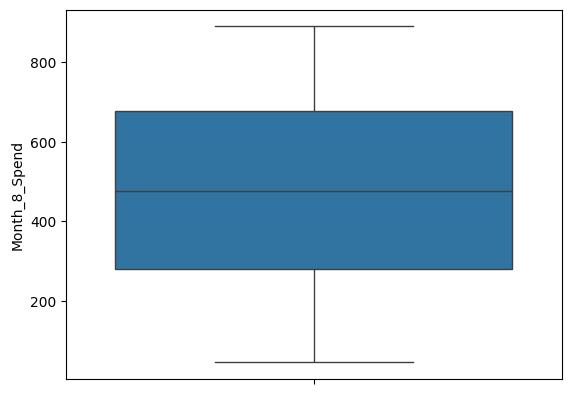

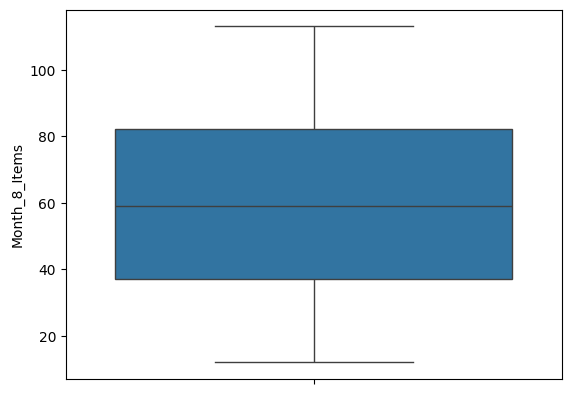

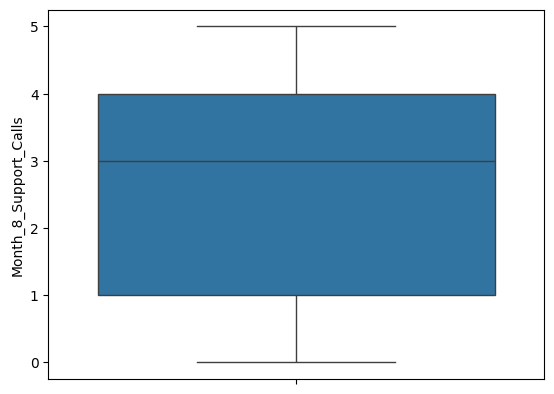

In [27]:
# univariate of month 8 quantities

sns.boxplot(data['Month_8_Spend'])
plt.show()
sns.boxplot(data['Month_8_Items'])
plt.show()
sns.boxplot(data['Month_8_Support_Calls'])
plt.show()

# nothing of interest to note here

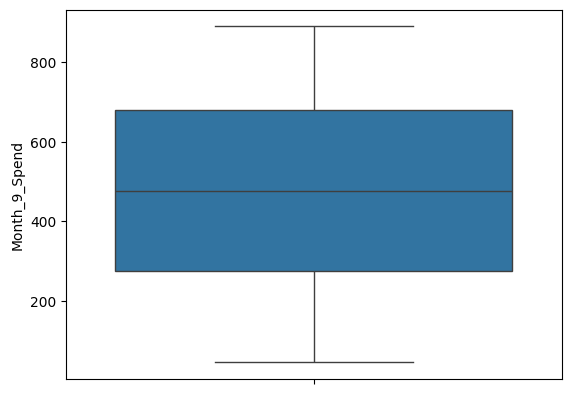

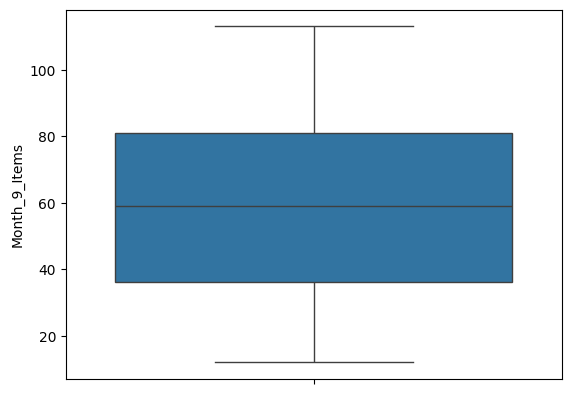

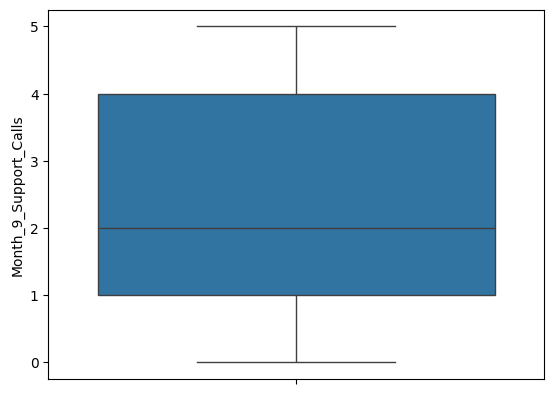

In [28]:
# univariate of month 9 quantities

sns.boxplot(data['Month_9_Spend'])
plt.show()
sns.boxplot(data['Month_9_Items'])
plt.show()
sns.boxplot(data['Month_9_Support_Calls'])
plt.show()

# nothing of interest to note here

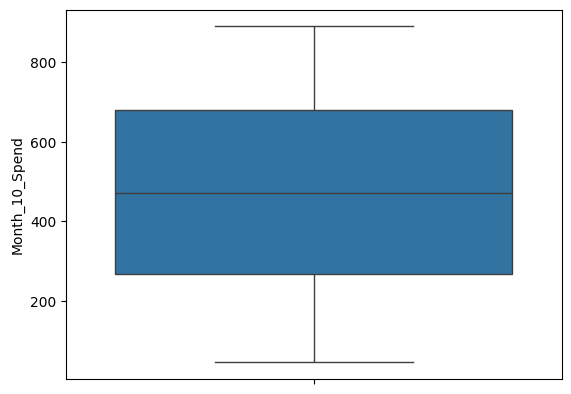

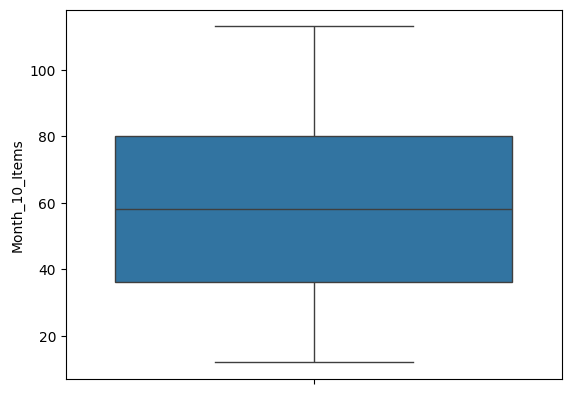

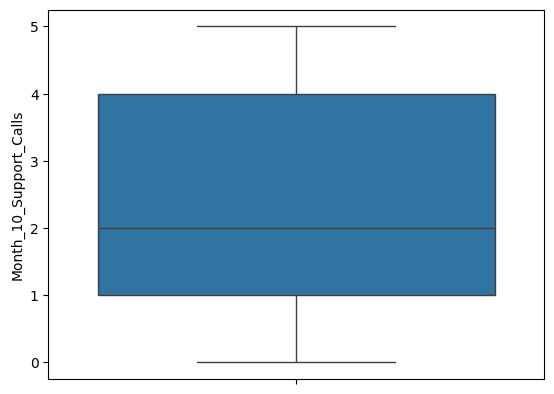

In [29]:
# univariate of month 10 quantities

sns.boxplot(data['Month_10_Spend'])
plt.show()
sns.boxplot(data['Month_10_Items'])
plt.show()
sns.boxplot(data['Month_10_Support_Calls'])
plt.show()

# nothing of interest to note here

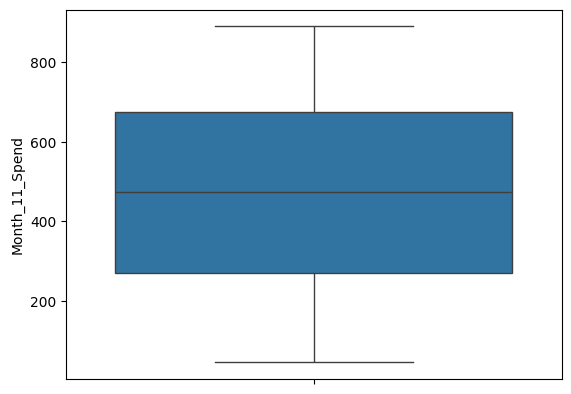

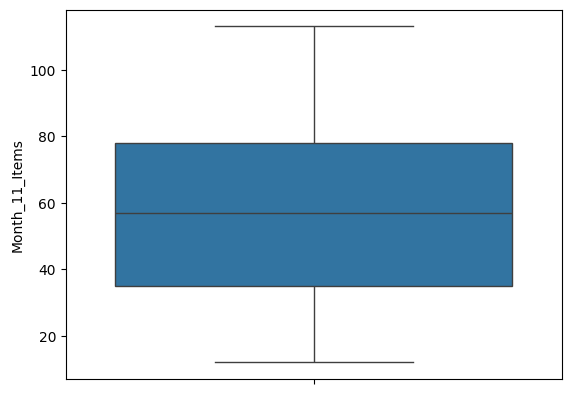

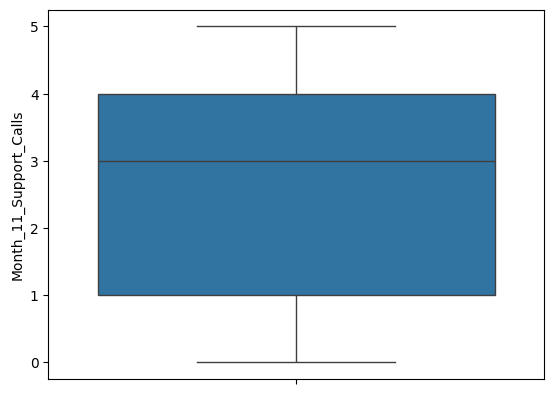

In [30]:
# univariate of month 11 quantities

sns.boxplot(data['Month_11_Spend'])
plt.show()
sns.boxplot(data['Month_11_Items'])
plt.show()
sns.boxplot(data['Month_11_Support_Calls'])
plt.show()

# nothing of interest to note here

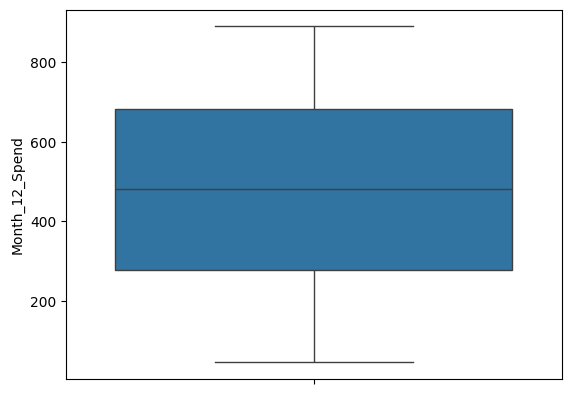

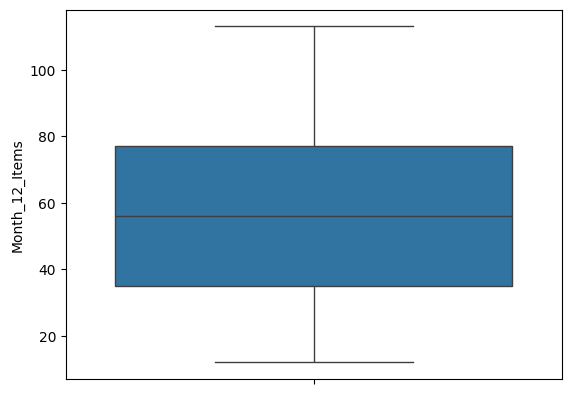

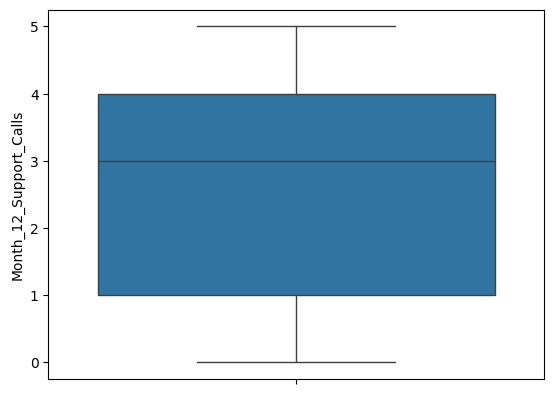

In [31]:
# univariate of month 12 quantities

sns.boxplot(data['Month_12_Spend'])
plt.show()
sns.boxplot(data['Month_12_Items'])
plt.show()
sns.boxplot(data['Month_12_Support_Calls'])
plt.show()

# nothing of interest to note here

In [33]:
# univariate analysis of all monthly columns yield nothing of interest (no outliers / odd trends)

<Axes: xlabel='Churn', ylabel='Count'>

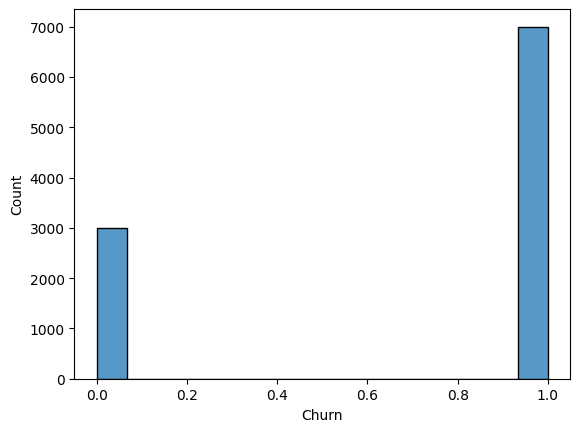

In [34]:
# examine churn via univariate analysis
sns.histplot(x=data['Churn'])

# many more churn than non churn records

In [35]:
# begin multivariate analysis

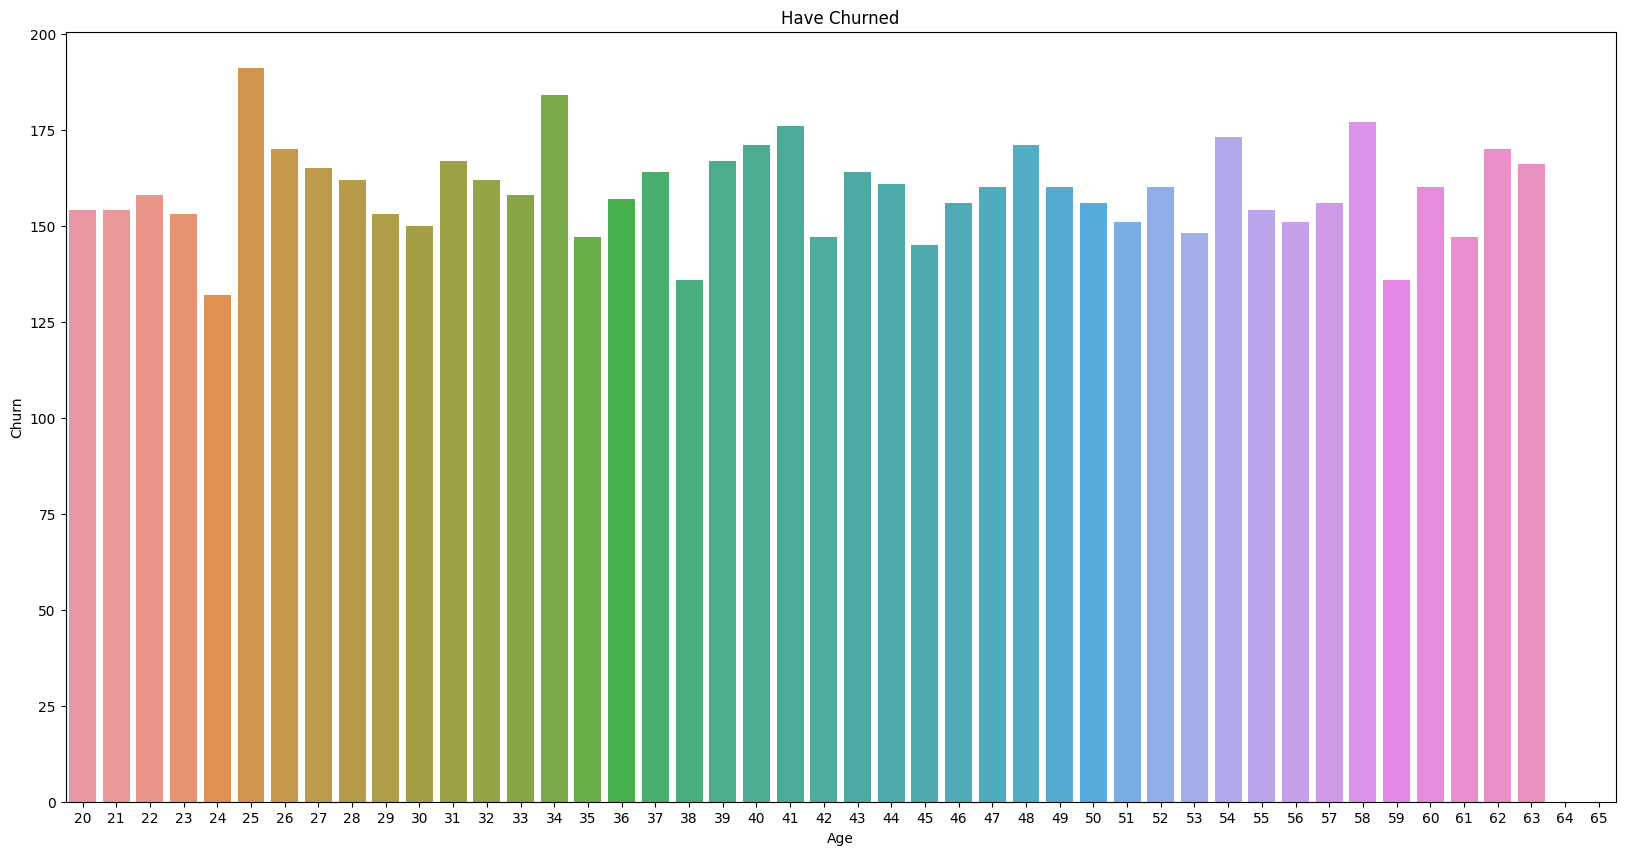

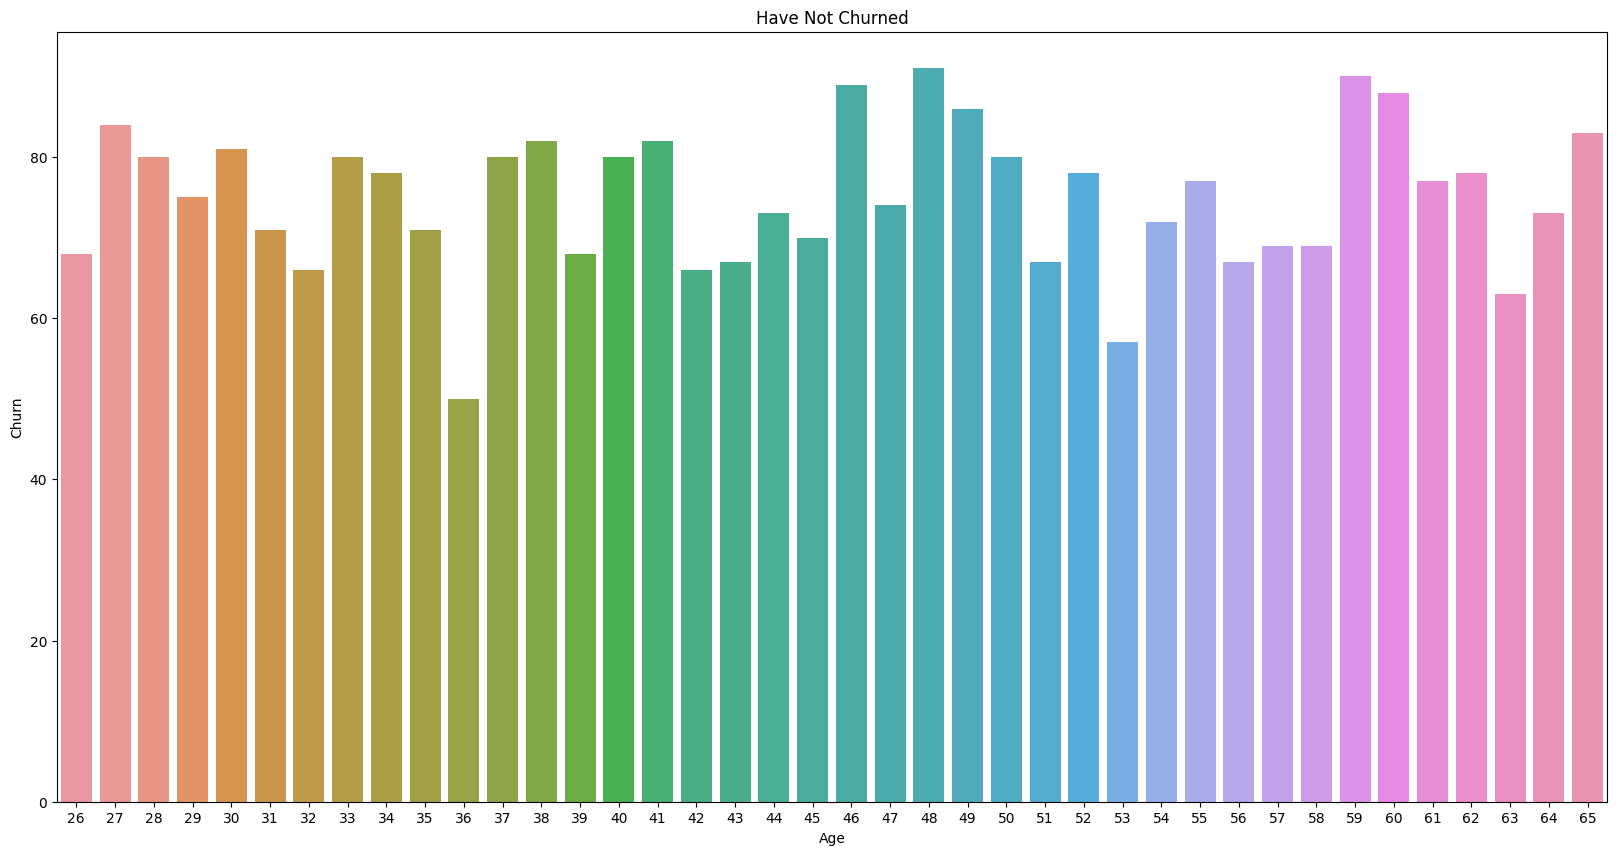

In [36]:
# compare age vs churn

# group by age
ages = data.groupby('Age')

# generate bar plot for how many customers have churned per age
# Note: Using count instead of sum would be incorrect, count will just return the number of people at that age
# Assuming has churned is represented as 1, then the sum of the churn column represents how many customers have churned at that age
plt.figure(figsize=(20,10))
sns.barplot(x=ages['Churn'].sum().index, y=ages['Churn'].sum())
plt.title("Have Churned")
plt.show()

# check for people who have not churned
noChurn = data[data['Churn'] == 0]
noChurnAge = noChurn.groupby('Age')
# using count here since sum of all who have not churned would be 0
plt.figure(figsize=(20,10))
sns.barplot(x=noChurnAge['Churn'].count().index, y=noChurnAge['Churn'].count())
plt.title("Have Not Churned")
plt.show()

# fewer people aged: 24 and under, 38, 46 and 59 have churned relative to other ages
# no one aged 64 and 65 have churned (will check this below)

# from these plots it is hard to say whether age has had an impact on churn or not
# the only oddity being no one aged 64/65 have churned

In [37]:
# verify no one aged 64 and 65 churned
data[(data['Age']==65) & (data['Churn']==1)]

,CustomerID,Age,Location,Device,Month_1_Spend,Month_1_Items,Month_1_Support_Calls,Month_2_Spend,Month_2_Items,Month_2_Support_Calls,...,Month_10_Spend,Month_10_Items,Month_10_Support_Calls,Month_11_Spend,Month_11_Items,Month_11_Support_Calls,Month_12_Spend,Month_12_Items,Month_12_Support_Calls,Churn


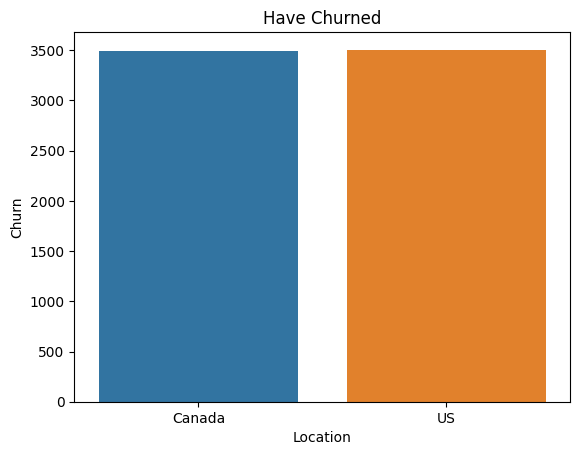

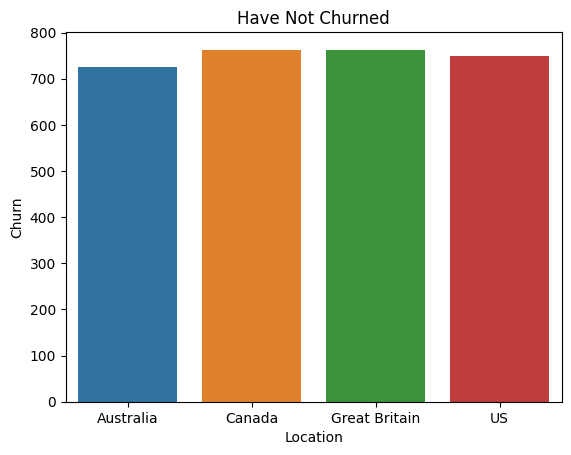

In [38]:
# multivariaate analysis of location vs churn

churn = data[data['Churn']==1]
loc = churn.groupby('Location')
sns.barplot(x=loc['Churn'].count().index, y=loc['Churn'].count())
plt.title('Have Churned')
plt.show()

noChurn = data[data['Churn']==0]
loc = noChurn.groupby('Location')
sns.barplot(x=loc['Churn'].count().index, y=loc['Churn'].count())
plt.title('Have Not Churned')
plt.show()

# all customers who have churned have been located in North America (CAN and USA)

# location definitely has a relation to churn

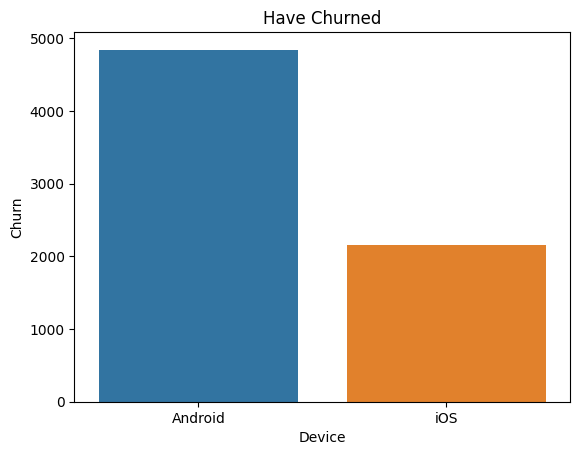

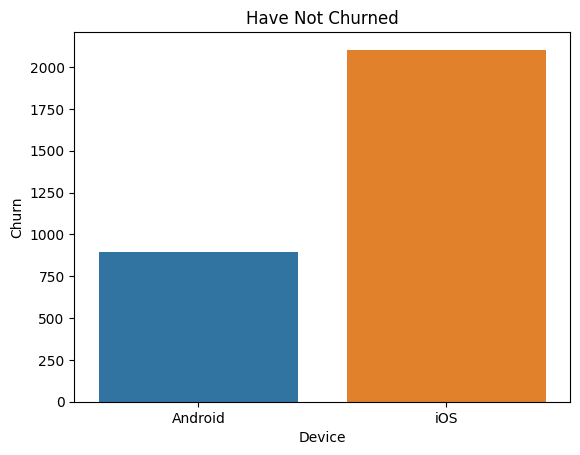

In [39]:
# multivariate analysis of device vs churn

churn = data[data['Churn']==1]
loc = churn.groupby('Device')
sns.barplot(x=loc['Churn'].count().index, y=loc['Churn'].count())
plt.title('Have Churned')
plt.show()

noChurn = data[data['Churn']==0]
loc = noChurn.groupby('Device')
sns.barplot(x=loc['Churn'].count().index, y=loc['Churn'].count())
plt.title('Have Not Churned')
plt.show()

# many more android users have churned than iOS users

# device has something to do with churn

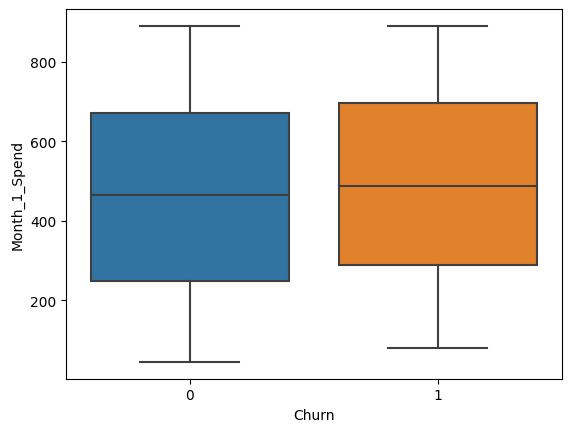

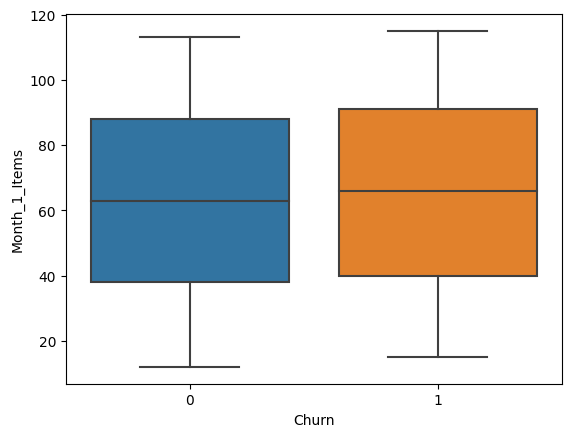

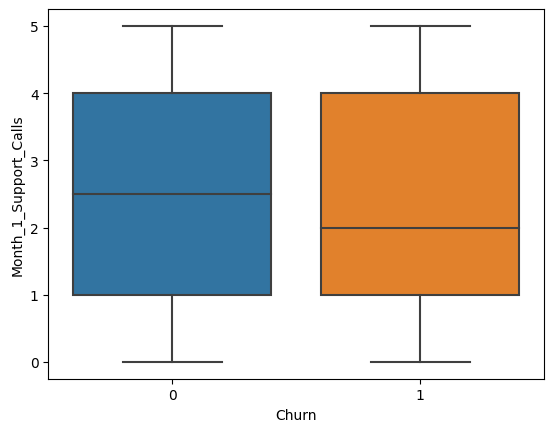

In [40]:
# multivariate analysis of month 1 qualities vs churn

sns.boxplot(x='Churn', y='Month_1_Spend', data=data)
plt.show()

sns.boxplot(x='Churn', y='Month_1_Items', data=data)
plt.show()

sns.boxplot(x='Churn', y='Month_1_Support_Calls', data=data)
plt.show()

# customers who churned spent slightly more, bought slightly more items and had fewer support calls on average in month 1
# data spread are nearly identical, medians are slightly shifted

# at this point month 1 does not appear to have a great impact on churn

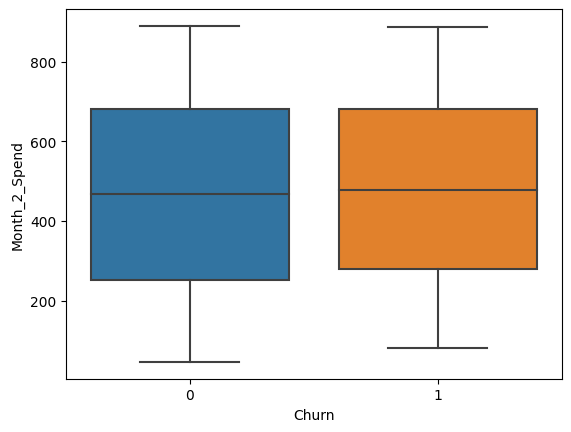

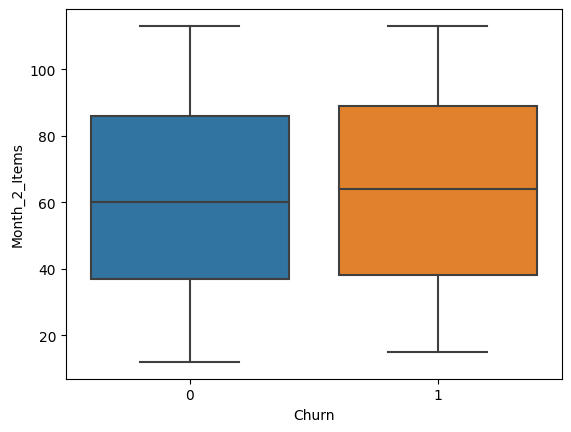

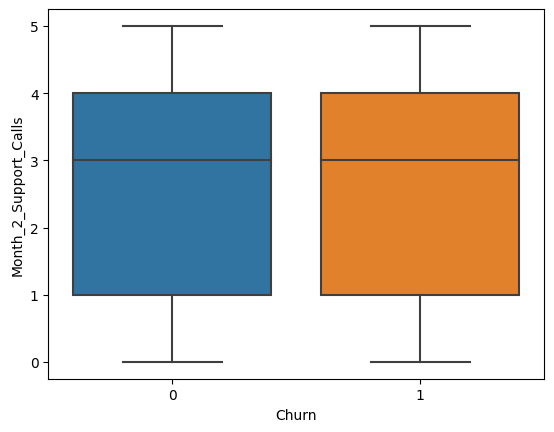

In [41]:
# multivariate analysis of month 2 qualities vs churn

sns.boxplot(x='Churn', y='Month_2_Spend', data=data)
plt.show()

sns.boxplot(x='Churn', y='Month_2_Items', data=data)
plt.show()

sns.boxplot(x='Churn', y='Month_2_Support_Calls', data=data)
plt.show()

# data spreads are nearly identical
# medians are very slightly shifted

# at this point, month 2 does not appear to have an effect on churn

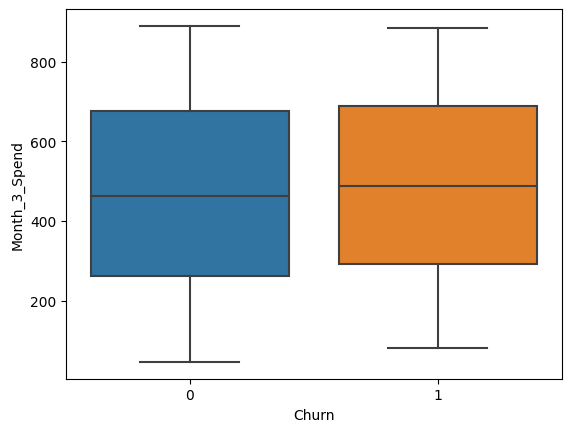

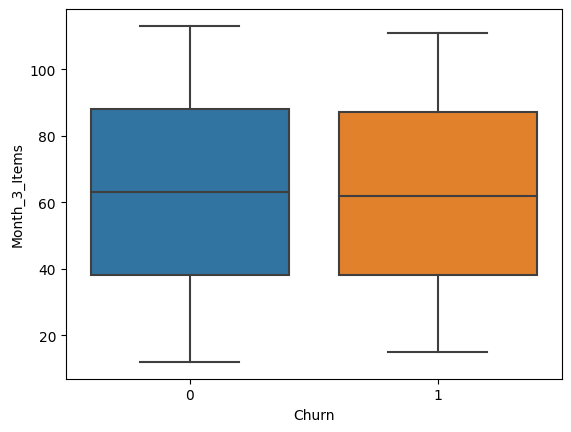

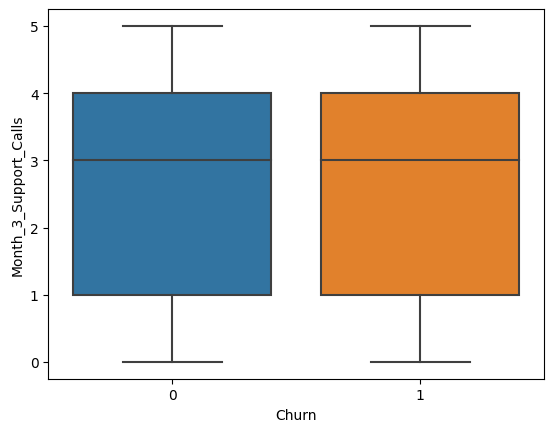

In [42]:
# multivariate analysis of month 3 qualities vs churn

sns.boxplot(x='Churn', y='Month_3_Spend', data=data)
plt.show()

sns.boxplot(x='Churn', y='Month_3_Items', data=data)
plt.show()

sns.boxplot(x='Churn', y='Month_3_Support_Calls', data=data)
plt.show()

# data spreads are nearly identical
# medians are very slightly shifted

# at this point, month 3 does not appear to have an effect on churn

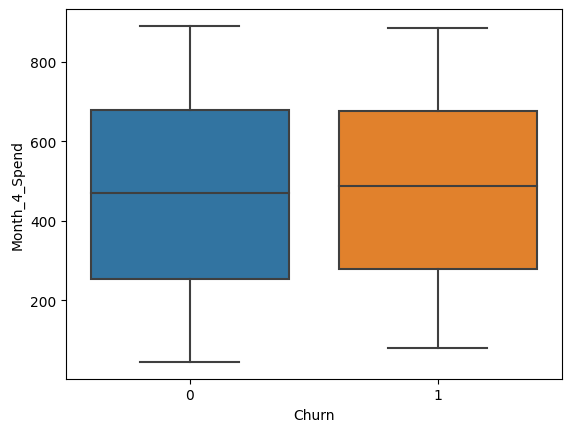

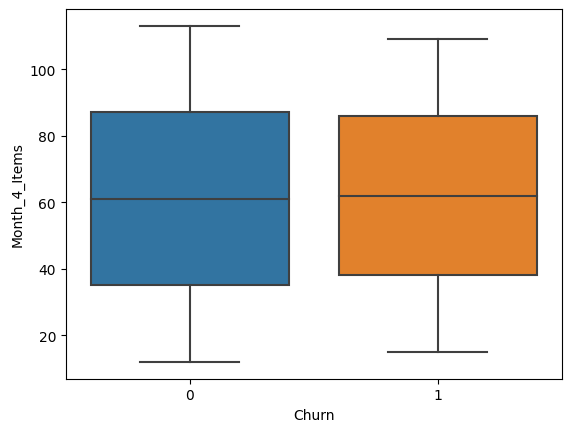

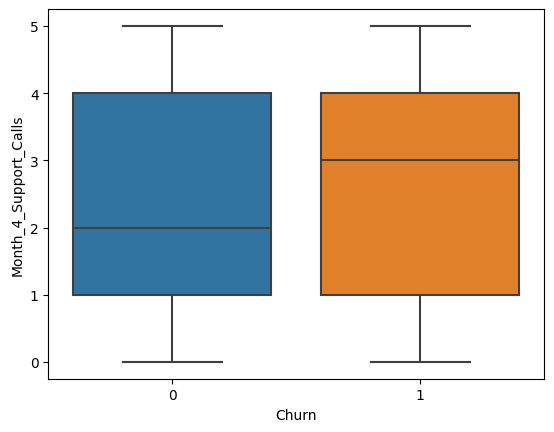

In [43]:
# multivariate analysis of month 4 qualities vs churn

sns.boxplot(x='Churn', y='Month_4_Spend', data=data)
plt.show()

sns.boxplot(x='Churn', y='Month_4_Items', data=data)
plt.show()

sns.boxplot(x='Churn', y='Month_4_Support_Calls', data=data)
plt.show()

# data spreads are nearly identical
# medians are very slightly shifted
# much lower median of support calls in not churned

# at this point, month 3 does not appear to have a significant effect on churn

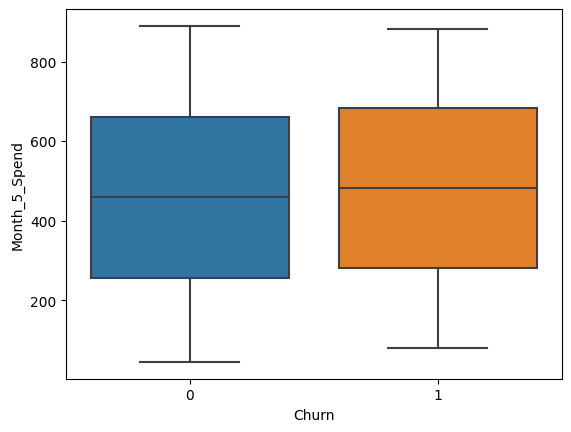

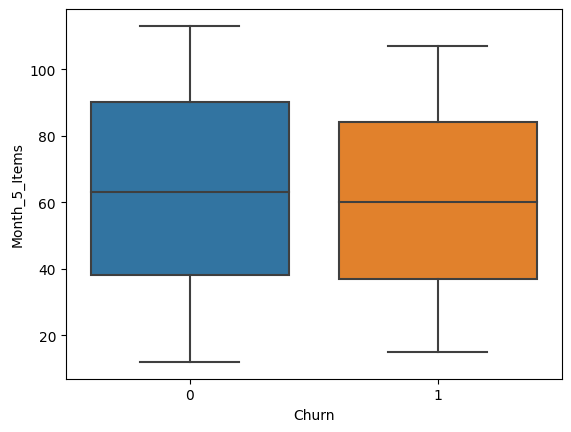

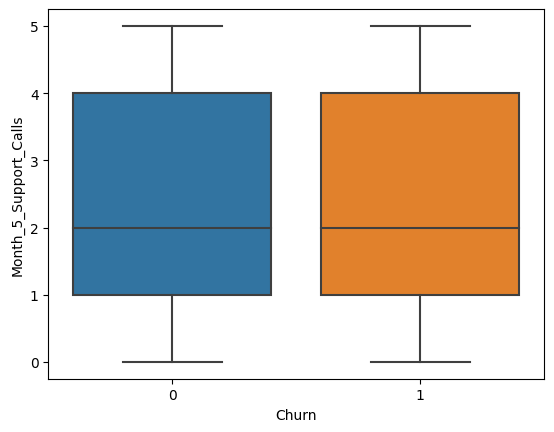

In [44]:
# multivariate analysis of month 5 qualities vs churn

sns.boxplot(x='Churn', y='Month_5_Spend', data=data)
plt.show()

sns.boxplot(x='Churn', y='Month_5_Items', data=data)
plt.show()

sns.boxplot(x='Churn', y='Month_5_Support_Calls', data=data)
plt.show()

# data spreads are nearly identical
# medians are very slightly shifted

# at this point, month 5 does not appear to have an effect on churn

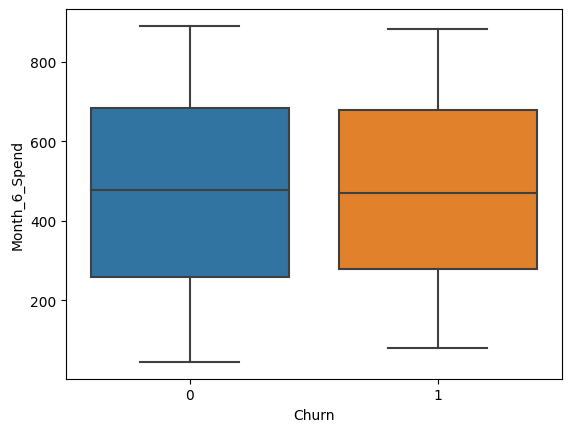

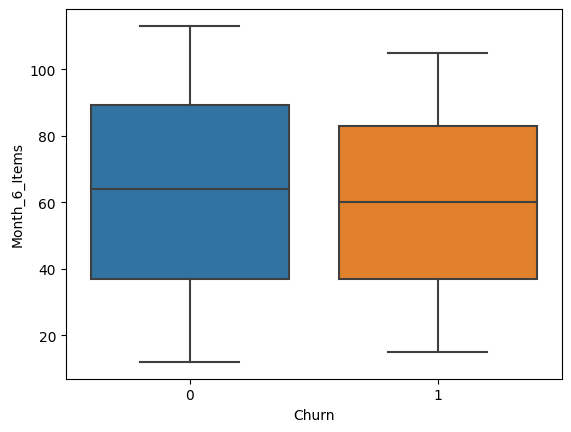

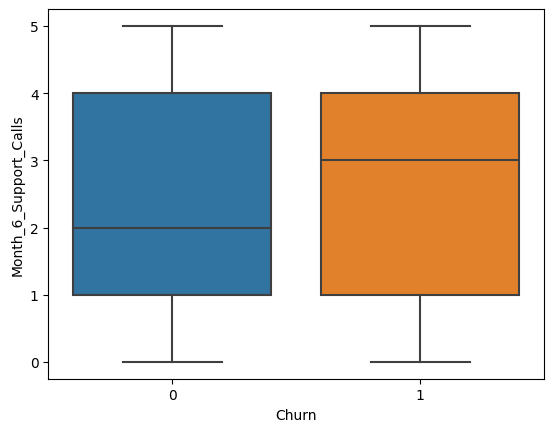

In [45]:
# multivariate analysis of month 6 qualities vs churn

sns.boxplot(x='Churn', y='Month_6_Spend', data=data)
plt.show()

sns.boxplot(x='Churn', y='Month_6_Items', data=data)
plt.show()

sns.boxplot(x='Churn', y='Month_6_Support_Calls', data=data)
plt.show()

# data spreads are similar, slightly bigger spread in items bought for not churned
# medians are slightly shifted

# at this point, month 6 does not appear to have a significant effect on churn

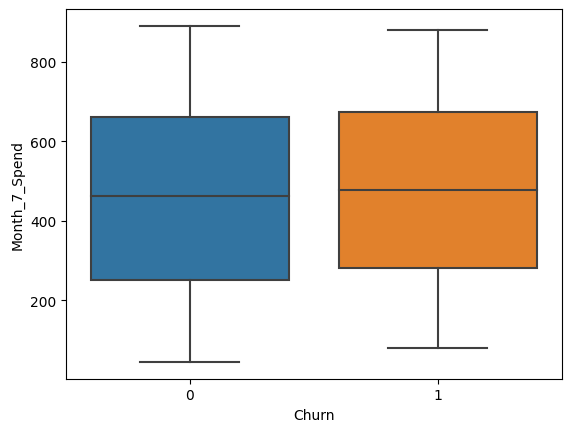

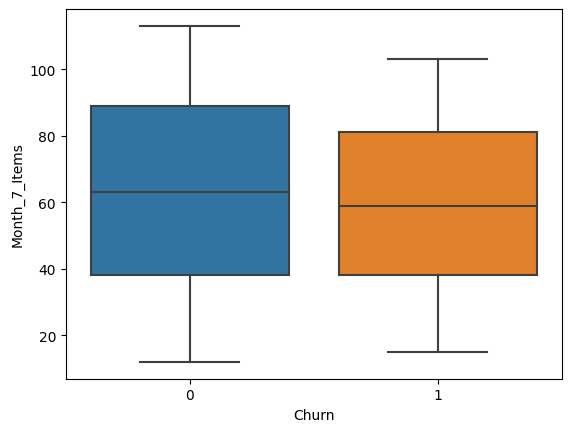

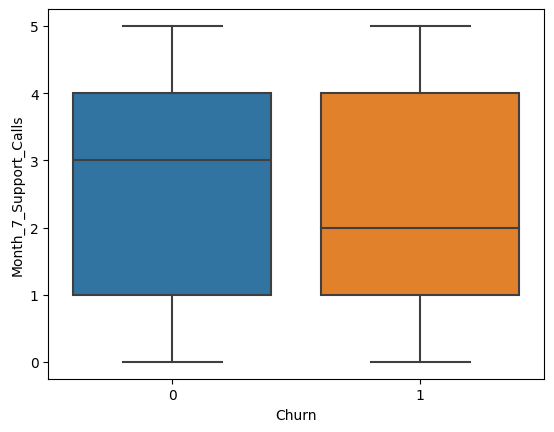

In [46]:
# multivariate analysis of month 7 qualities vs churn

sns.boxplot(x='Churn', y='Month_7_Spend', data=data)
plt.show()

sns.boxplot(x='Churn', y='Month_7_Items', data=data)
plt.show()

sns.boxplot(x='Churn', y='Month_7_Support_Calls', data=data)
plt.show()

# data spreads are nearly identical
# data spreads are similar, slightly bigger spread in items bought for not churned

# medians are slightly shifted, lower median support calls for those who churned

# at this point, month 7 does not appear to have a significant effect on churn

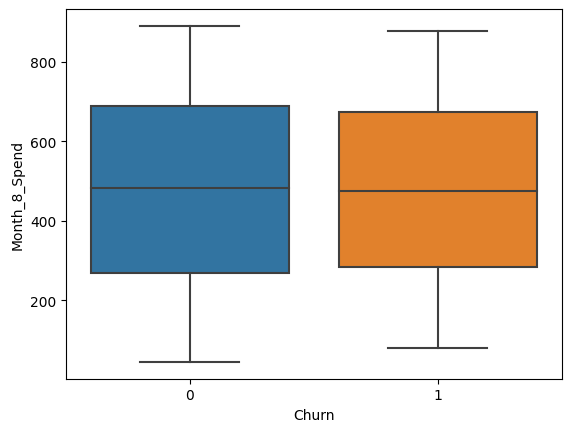

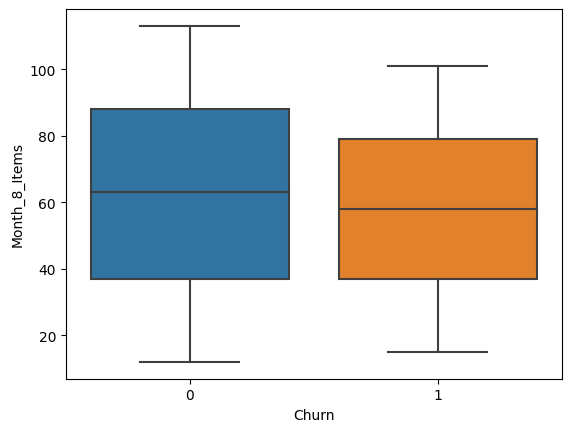

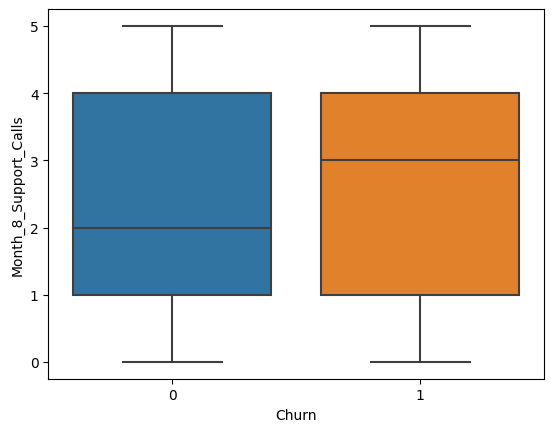

In [47]:
# multivariate analysis of month 8 qualities vs churn

sns.boxplot(x='Churn', y='Month_8_Spend', data=data)
plt.show()

sns.boxplot(x='Churn', y='Month_8_Items', data=data)
plt.show()

sns.boxplot(x='Churn', y='Month_8_Support_Calls', data=data)
plt.show()

# data spreads are nearly identical, not churned has slightly bigger spread for items bought
# medians are very slightly shifted, lower median for support calls for those who churned

# at this point, month 8 does not appear to have a significant effect on churn

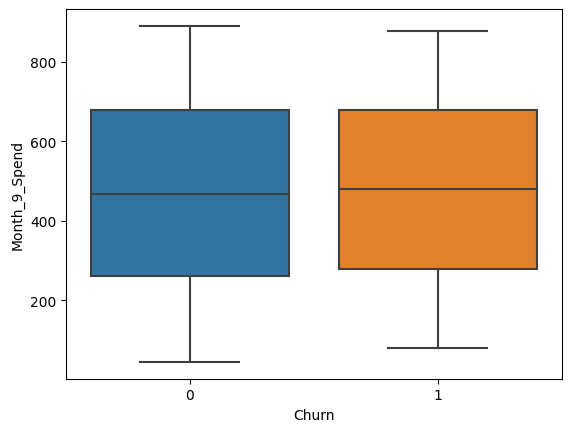

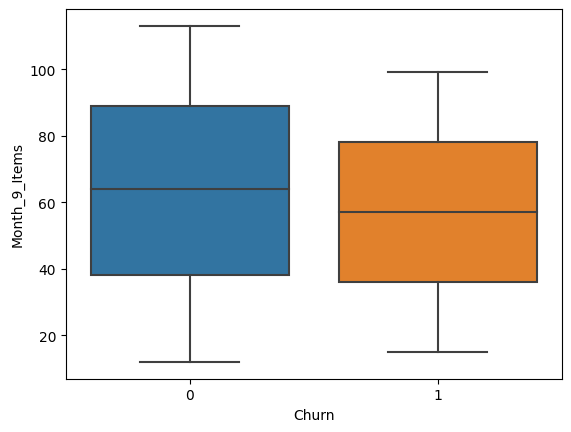

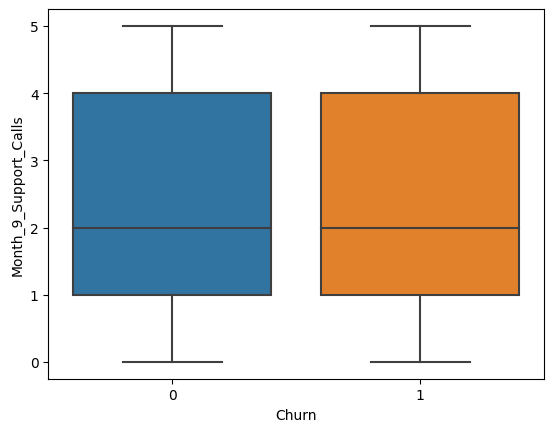

In [48]:
# multivariate analysis of month 9 qualities vs churn

sns.boxplot(x='Churn', y='Month_9_Spend', data=data)
plt.show()

sns.boxplot(x='Churn', y='Month_9_Items', data=data)
plt.show()

sns.boxplot(x='Churn', y='Month_9_Support_Calls', data=data)
plt.show()

# data spreads are nearly identical, slightly larger spread in items bought for those who did not churn
# medians are very slightly shifted

# at this point, month 9 does not appear to have an effect on churn

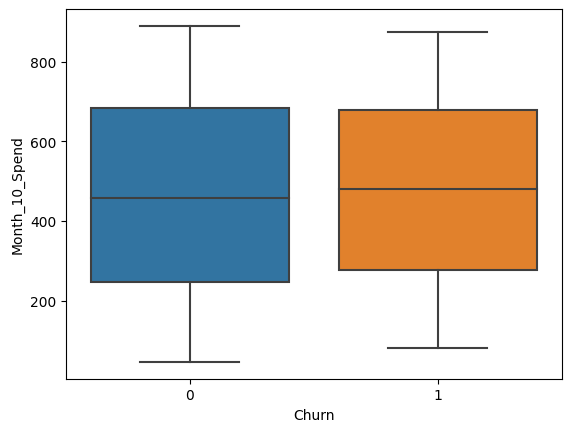

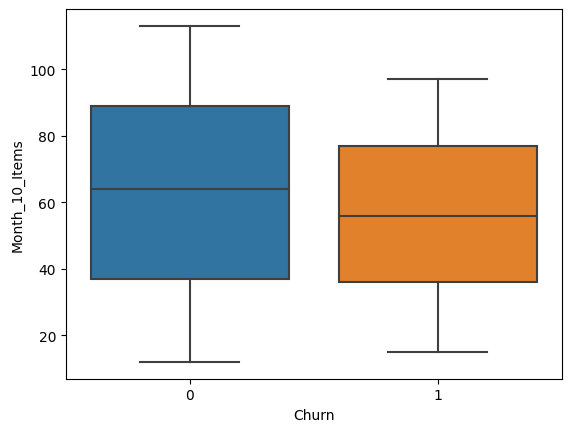

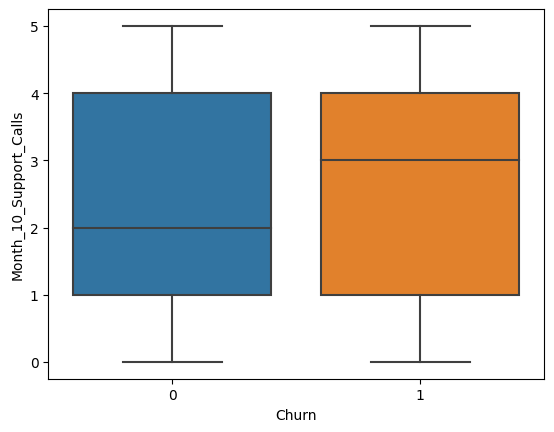

In [49]:
# multivariate analysis of month 10 qualities vs churn

sns.boxplot(x='Churn', y='Month_10_Spend', data=data)
plt.show()

sns.boxplot(x='Churn', y='Month_10_Items', data=data)
plt.show()

sns.boxplot(x='Churn', y='Month_10_Support_Calls', data=data)
plt.show()

# data spreads are nearly identical, slightly bigger spread in items bought for those who did not churn
# medians are very slightly shifted, slightly higher median in support calls for those who churned

# at this point, month 10 does not appear to have an effect on churn

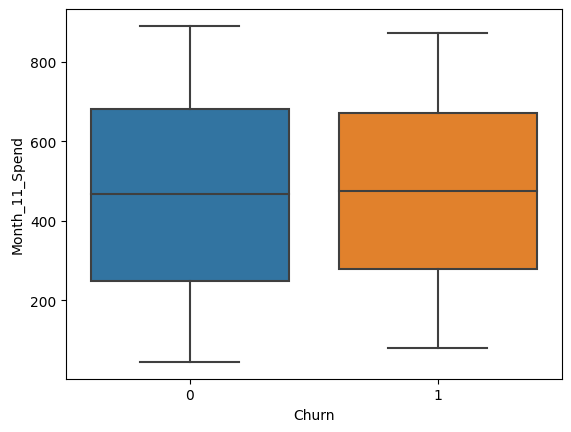

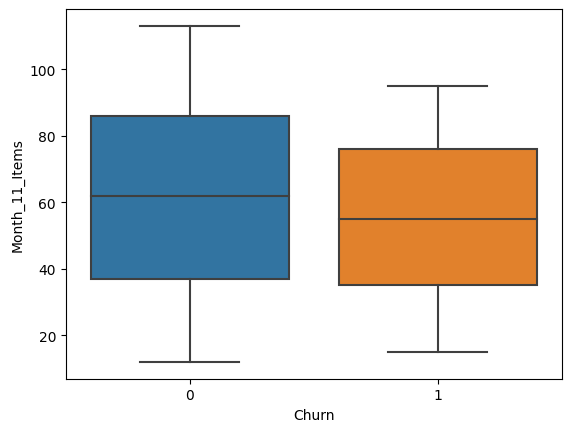

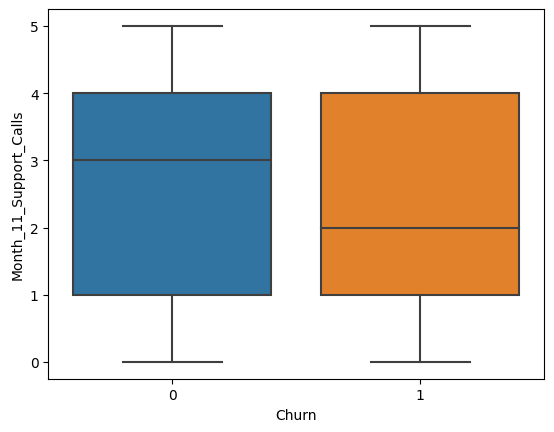

In [50]:
# multivariate analysis of month 11 qualities vs churn

sns.boxplot(x='Churn', y='Month_11_Spend', data=data)
plt.show()

sns.boxplot(x='Churn', y='Month_11_Items', data=data)
plt.show()

sns.boxplot(x='Churn', y='Month_11_Support_Calls', data=data)
plt.show()

# data spreads are nearly identical, larger spread of data for items bought among customers who did not churn
# medians are very slightly shifted, less support calls made by those who did churn

# at this point, month 11 does not appear to have an effect on churn

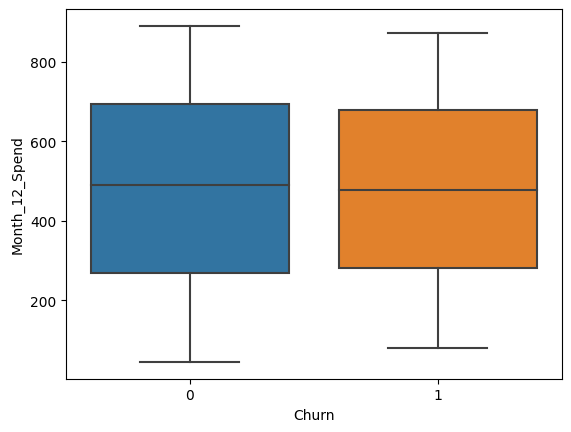

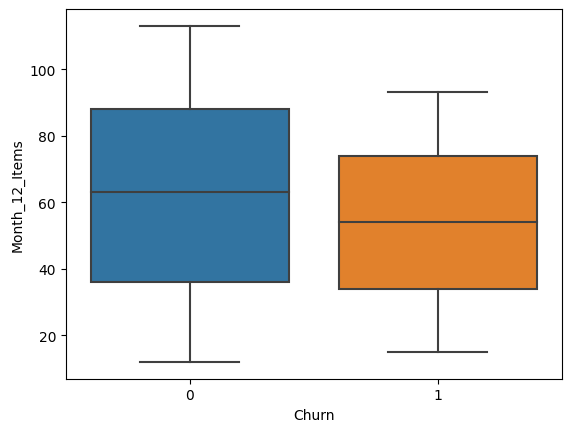

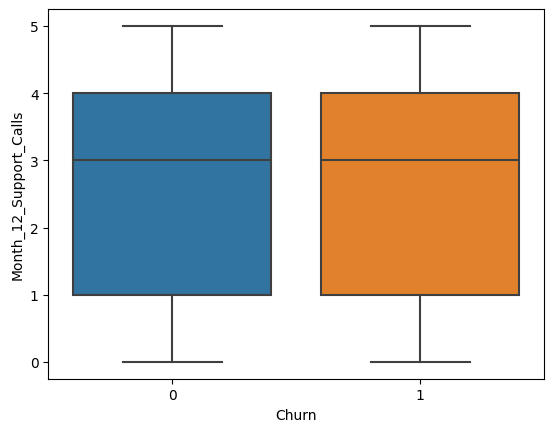

In [51]:
# multivariate analysis of month 12 qualities vs churn

sns.boxplot(x='Churn', y='Month_12_Spend', data=data)
plt.show()

sns.boxplot(x='Churn', y='Month_12_Items', data=data)
plt.show()

sns.boxplot(x='Churn', y='Month_12_Support_Calls', data=data)
plt.show()

# data spreads are nearly identical, larger spread of items bought for those who did not churn
# medians are very slightly shifted

# at this point, month 12 does not appear to have an effect on churn

### Feature Engineering

* The monthly values do not seem to be super useful this spread out

* Will create quarterly average of the quantites (every 3 months) and see if these yield more meaningful trends

* All categorical columns will have feature engineering applied to them in the data pipeline

* All numerical columns will have either min-max or standard scaling applied to them in the data pipeline

In [52]:
# create new columns

data['Q1_Spend'] = (data['Month_1_Spend'] + data['Month_2_Spend'] + data['Month_3_Spend']) / 3

data['Q1_Items'] = (data['Month_1_Items'] + data['Month_2_Items'] + data['Month_3_Items']) / 3

data['Q1_Support_Calls'] = (data['Month_1_Support_Calls'] + data['Month_2_Support_Calls'] + data['Month_3_Support_Calls']) / 3

data['Q2_Spend'] = (data['Month_4_Spend'] + data['Month_5_Spend'] + data['Month_6_Spend']) / 3

data['Q2_Items'] = (data['Month_4_Items'] + data['Month_5_Items'] + data['Month_6_Items']) / 3

data['Q2_Support_Calls'] = (data['Month_4_Support_Calls'] + data['Month_5_Support_Calls'] + data['Month_6_Support_Calls']) / 3

data['Q3_Spend'] = (data['Month_7_Spend'] + data['Month_8_Spend'] + data['Month_9_Spend']) / 3

data['Q3_Items'] = (data['Month_7_Items'] + data['Month_8_Items'] + data['Month_9_Items']) / 3

data['Q3_Support_Calls'] = (data['Month_7_Support_Calls'] + data['Month_8_Support_Calls'] + data['Month_9_Support_Calls']) / 3

data['Q4_Spend'] = (data['Month_10_Spend'] + data['Month_11_Spend'] + data['Month_12_Spend']) / 3

data['Q4_Items'] = (data['Month_10_Items'] + data['Month_11_Items'] + data['Month_12_Items']) / 3

data['Q4_Support_Calls'] = (data['Month_10_Support_Calls'] + data['Month_11_Support_Calls'] + data['Month_12_Support_Calls']) / 3

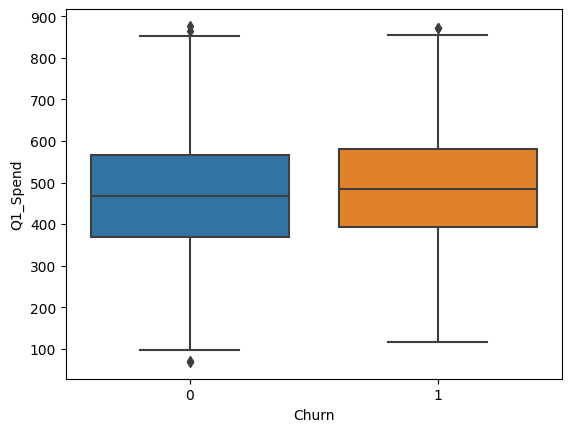

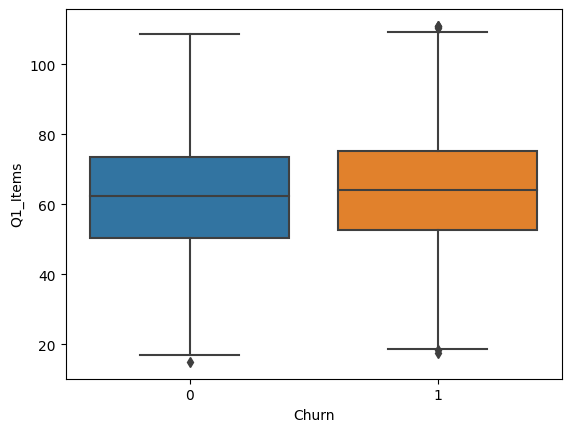

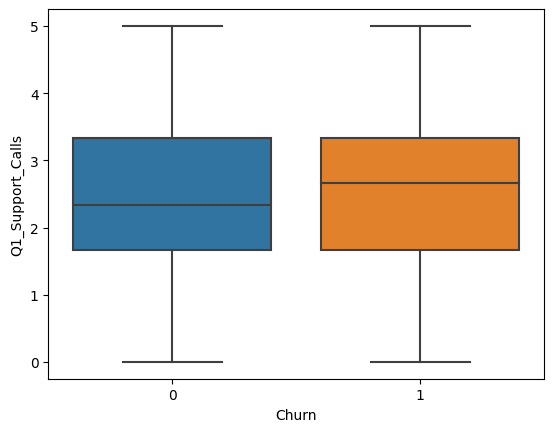

      CustomerID  Age       Location   Device  Month_1_Spend  Month_1_Items  Month_1_Support_Calls  Month_2_Spend  Month_2_Items  Month_2_Support_Calls  Month_3_Spend  Month_3_Items  Month_3_Support_Calls  Month_4_Spend  Month_4_Items  Month_4_Support_Calls  Month_5_Spend  Month_5_Items  Month_5_Support_Calls  Month_6_Spend  Month_6_Items  Month_6_Support_Calls  Month_7_Spend  Month_7_Items  Month_7_Support_Calls  Month_8_Spend  Month_8_Items  Month_8_Support_Calls  Month_9_Spend  Month_9_Items  Month_9_Support_Calls  Month_10_Spend  Month_10_Items  Month_10_Support_Calls  Month_11_Spend  Month_11_Items  Month_11_Support_Calls  Month_12_Spend  Month_12_Items  Month_12_Support_Calls  Churn   Q1_Spend   Q1_Items  Q1_Support_Calls    Q2_Spend   Q2_Items  Q2_Support_Calls    Q3_Spend   Q3_Items  Q3_Support_Calls    Q4_Spend   Q4_Items  Q4_Support_Calls
8554        8555   28         Canada  Android     167.069658             96                      0      61.683281             53           

In [53]:
# re-run multivariate analysis on these vs churn

sns.boxplot(x='Churn', y='Q1_Spend', data=data)
plt.show()

sns.boxplot(x='Churn', y='Q1_Items', data=data)
plt.show()

sns.boxplot(x='Churn', y='Q1_Support_Calls', data=data)
plt.show()

# for those who have churned:
# higher median spend, higher spread
# higher median items bought, higher spread
# higher median support calls, same spread
# does appear to have some impact on churn

# some odd outliers appearing
print(data[data['Q1_Spend'] < 100].to_string())
print(data[data['Q1_Spend'] > 850].to_string())
print(data[data['Q1_Items'] < 18].to_string())
print(data[data['Q1_Items'] > 110].to_string())

# while the values are odd, they do line up with what the customers spent
# will drop these for now since they deviate heavily from the expected data ranges
# may cause difficulties with models that are snensitive to outliers

data = data[(data['Q1_Spend'] > 100) & (data['Q1_Spend'] < 850)]
data = data[(data['Q1_Items'] > 19) & (data['Q1_Items'] < 110)]

# will repeat the plots below to see them without the outliers

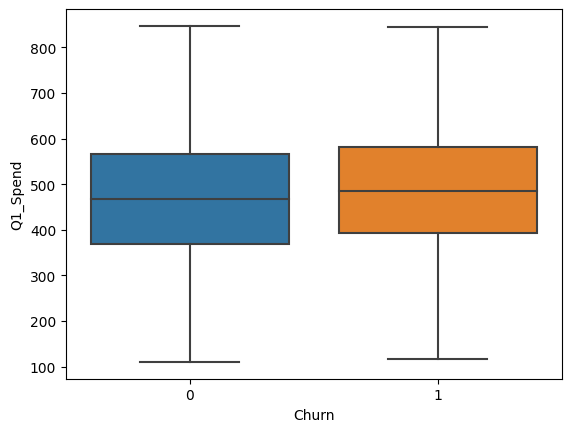

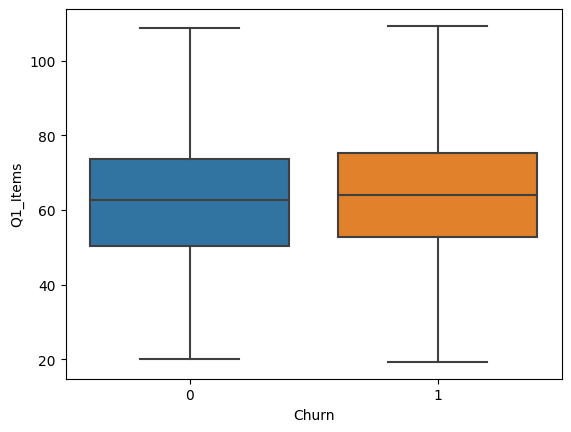

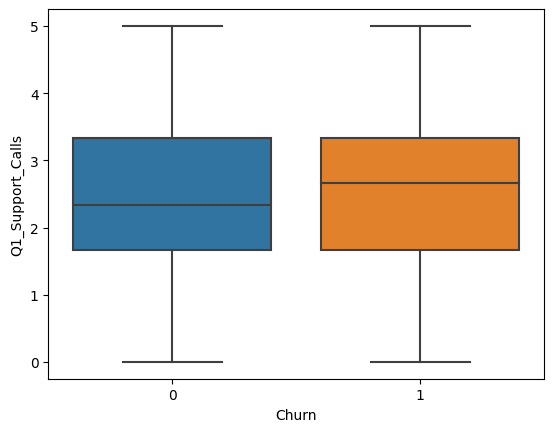

In [54]:
# repeat above plots
sns.boxplot(x='Churn', y='Q1_Spend', data=data)
plt.show()

sns.boxplot(x='Churn', y='Q1_Items', data=data)
plt.show()

sns.boxplot(x='Churn', y='Q1_Support_Calls', data=data)
plt.show()

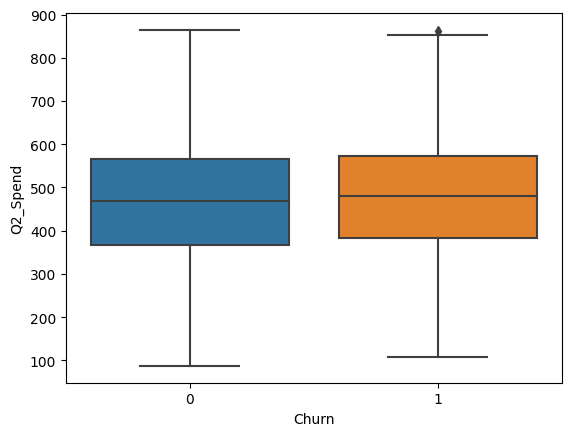

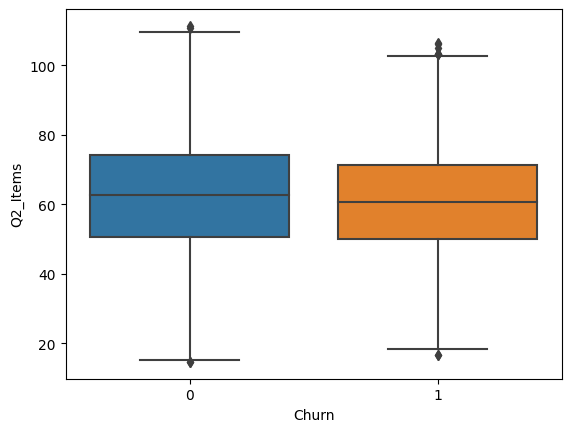

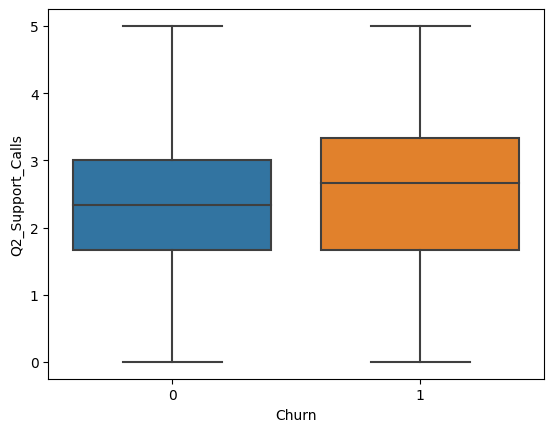

In [55]:
# repeat for Q2

sns.boxplot(x='Churn', y='Q2_Spend', data=data)
plt.show()

sns.boxplot(x='Churn', y='Q2_Items', data=data)
plt.show()

sns.boxplot(x='Churn', y='Q2_Support_Calls', data=data)
plt.show()

# for churned:
# slightly higher median spend, higher valued data range
# smaller data range for items, lower median
# bigger range for support calls, higher median

# does appear to impact churn

# will handle outliers same way was above and repeat plots below

data = data[data['Q2_Spend'] < 850]
data = data[(data['Q2_Items'] < 95) & (data['Q2_Items'] > 22)]

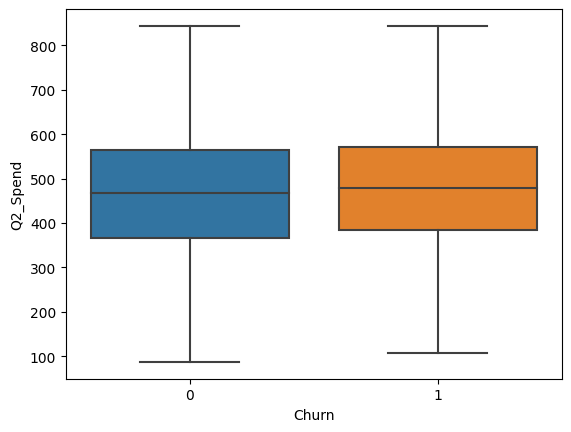

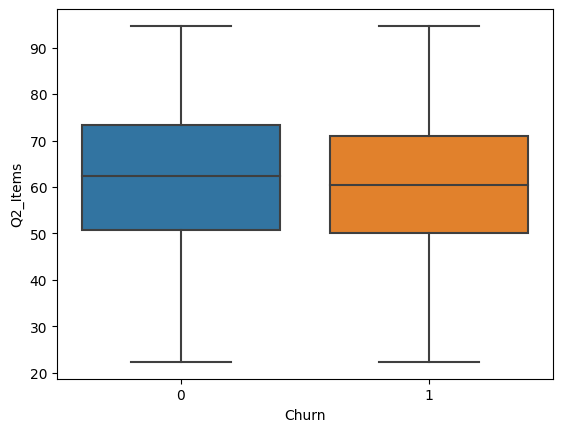

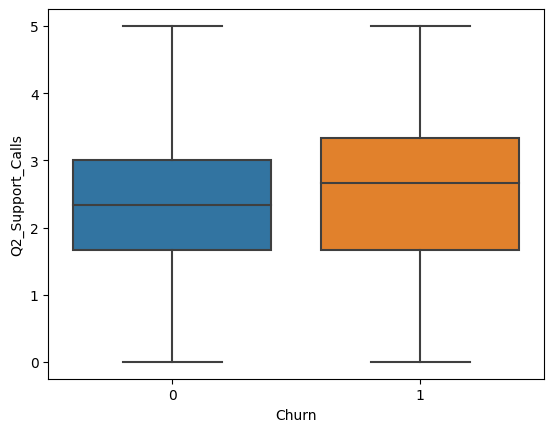

In [56]:
# re-run q2 plots
sns.boxplot(x='Churn', y='Q2_Spend', data=data)
plt.show()

sns.boxplot(x='Churn', y='Q2_Items', data=data)
plt.show()

sns.boxplot(x='Churn', y='Q2_Support_Calls', data=data)
plt.show()

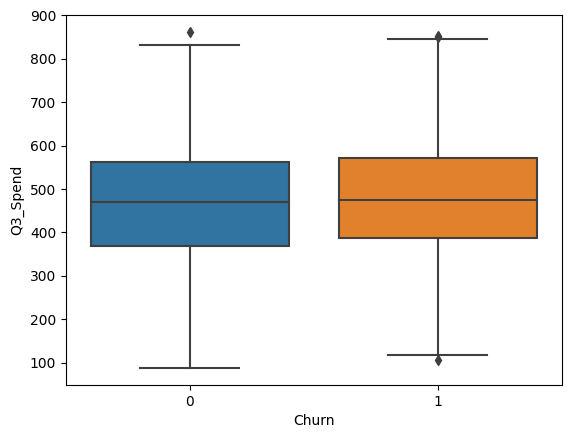

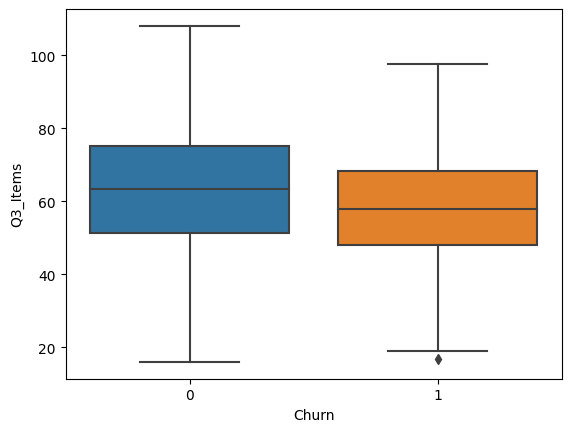

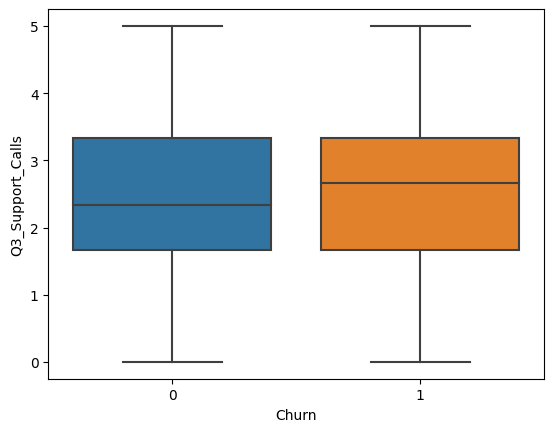

In [57]:
# repeat for q3

sns.boxplot(x='Churn', y='Q3_Spend', data=data)
plt.show()

sns.boxplot(x='Churn', y='Q3_Items', data=data)
plt.show()

sns.boxplot(x='Churn', y='Q3_Support_Calls', data=data)
plt.show()

# for churned:
# smaller spread for spend, slightly higher median
# smaller spread for items, lower median
# same spread for calls, higher median

# same process for outliers, will re-run plots below
data = data[(data['Q3_Spend'] > 150) & (data['Q3_Spend'] < 800)]
data = data[data['Q3_Items'] > 22]

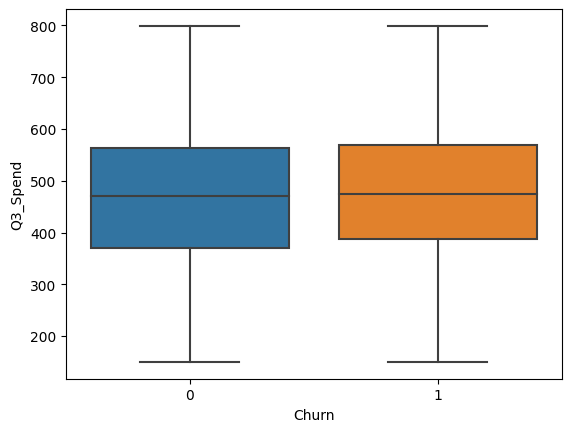

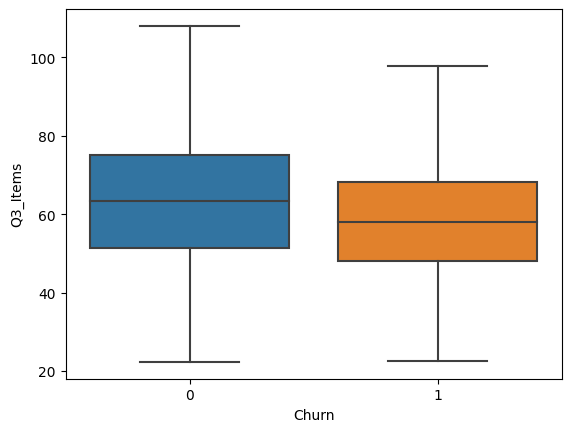

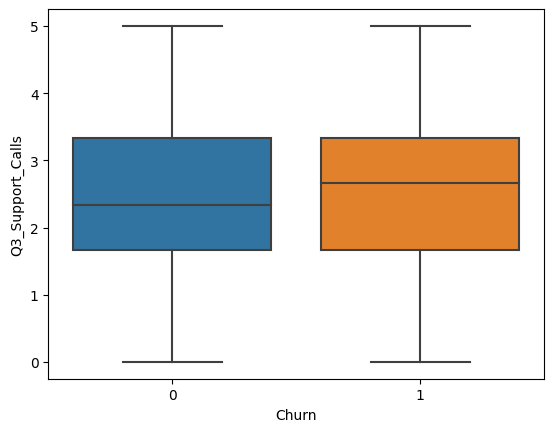

In [58]:
# re-run plots for q3

sns.boxplot(x='Churn', y='Q3_Spend', data=data)
plt.show()

sns.boxplot(x='Churn', y='Q3_Items', data=data)
plt.show()

sns.boxplot(x='Churn', y='Q3_Support_Calls', data=data)
plt.show()

# For churned:
# similar spread in spend, similar median
# smaller spread in items, lower median
# same spread in calls, higher median

# calls and items seem to relate to churn

# no outliers

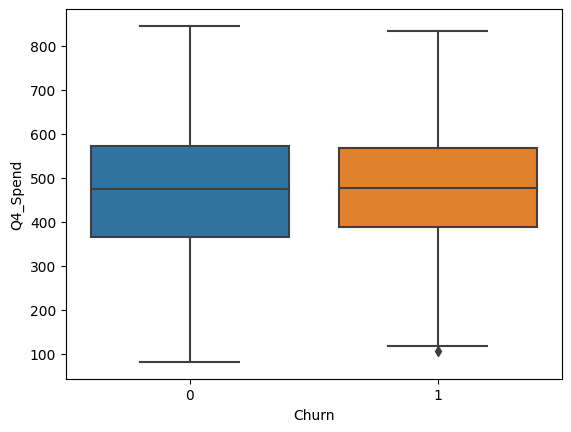

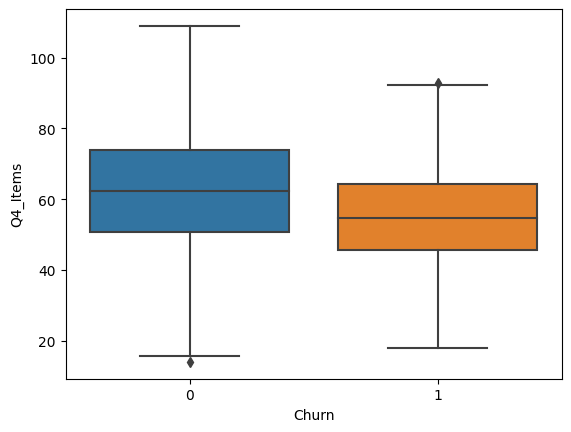

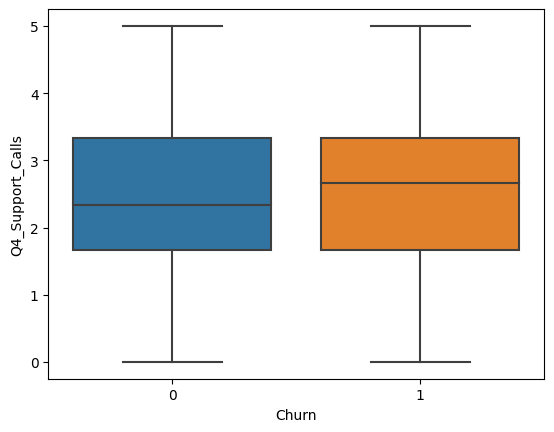

In [59]:
# repeat process for q4
sns.boxplot(x='Churn', y='Q4_Spend', data=data)
plt.show()

sns.boxplot(x='Churn', y='Q4_Items', data=data)
plt.show()

sns.boxplot(x='Churn', y='Q4_Support_Calls', data=data)
plt.show()

In [60]:
# items and spend from q1 and q2 seems to impact churn, perhaps they are too early in the process
# calls from q1 and q2 seem to impact churn

# spend from q3 and q4 seem to have no impact on churn
# but items and calls do

### Hypothesis

Based on the above analysis, it is predicted that the following features have an impact on whether or not a customer will churn: Location, Device, Support calls from all quarters, amount of items bought in Q3 and Q4.

### Modelling

* Will build a data pipeline

* Will try several different models and rank them by their f1 scores

In [61]:
# build data pipeline

# create data pipeline for logistic regression
catFeatures = ['Location', 'Device'] 
numFeatures = ['Q1_Support_Calls', 'Q2_Support_Calls', 'Q3_Support_Calls', 'Q4_Support_Calls', 'Q3_Items', 'Q4_Items']
target = ['Churn']

# train and test set
x_train, x_test, y_train, y_test = train_test_split(data[catFeatures + numFeatures], data[target], test_size=0.3, random_state=1)

# build pipeline, transformers
# apply one hot encoding, scaling
# prevent one hot encoder from returning a sparse matrix (GuassianNB will throw an error otherwise)
catTransformer = Pipeline(steps = [('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))])
numTransformer = Pipeline(steps = [('scaler', MinMaxScaler())])

# build preprocessor
preprocessor = ColumnTransformer(transformers = [('cat', catTransformer, catFeatures), ('num', numTransformer, numFeatures)])

In [62]:
# start with logistic regression

logRegress = Pipeline(steps = [('preprocessor', preprocessor), ('logistic', LogisticRegression())])

# fit model
logRegress.fit(x_train, y_train)

# predictions
pred = logRegress.predict(x_test)

# performance metrics (binary)
accuracy = accuracy_score(y_test, pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, pred, average='binary')
print("Precision:", precision)

recall = recall_score(y_test, pred, average='binary')
print("Recall Score:", recall)

f1 = f1_score(y_test, pred, average='binary')
print("F1 Score:", f1)

# cross validation
crossVal = cross_val_score(logRegress, x_train, y_train, cv=10, scoring='f1')

# print scores
print("Cross Validation F1 Scores:", crossVal)
print("Mean cross validation F1 Score:", np.mean(crossVal))

# high f1 score, 90
# score is maintained in cross validation

c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.

Accuracy: 0.8578329882677709
Precision: 0.8492230155396892
Recall Score: 0.9744578313253012
F1 Score: 0.90754039497307


c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.

Cross Validation F1 Scores: [0.91796875 0.90749757 0.90143541 0.921875   0.90677134 0.90434783
 0.91577928 0.90241546 0.91121951 0.90838207]
Mean cross validation F1 Score: 0.9097692214015289


c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [63]:
# test naieve bayes next

nb = Pipeline(steps = [('preprocessor', preprocessor), ('nb', GaussianNB())])

# fit
nb.fit(x_train, y_train)

# predict
pred = nb.predict(x_test)

# metrics
accuracy = accuracy_score(y_test, pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, pred, average='binary')
print("Precision:", precision)

recall = recall_score(y_test, pred, average='binary')
print("Recall Score:", recall)

f1 = f1_score(y_test, pred, average='binary')
print("F1 Score:", f1)

# cross validation
crossVal = cross_val_score(nb, x_train, y_train, cv=10, scoring='f1')

# print scores
print("Cross Validation F1 Scores:", crossVal)
print("Mean cross validation F1 Score:", np.mean(crossVal))

# strong f1 score, 90, similar to logistic regression
# recall is perfect, slightly odd
# very slight reduction in f1 score after cross validation, likely not a concern

c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.

Accuracy: 0.8536922015182885
Precision: 0.8303321328531412
Recall Score: 1.0
F1 Score: 0.9073021425448186


c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.

Cross Validation F1 Scores: [0.905804   0.90666667 0.89138577 0.91538462 0.90648855 0.8987701
 0.90218424 0.89369708 0.9047619  0.9082218 ]
Mean cross validation F1 Score: 0.9033364721049999


c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [64]:
# test SVM

svm = Pipeline(steps = [('preprocessor', preprocessor), ('svm', SVC(random_state=1))])

# fit
svm.fit(x_train, y_train)

# predict
pred = svm.predict(x_test)

# metrics
accuracy = accuracy_score(y_test, pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, pred, average='binary')
print("Precision:", precision)

recall = recall_score(y_test, pred, average='binary')
print("Recall Score:", recall)
f1 = f1_score(y_test, pred, average='binary')
print("F1 Score:", f1)

# cross validation
crossVal = cross_val_score(svm, x_train, y_train, cv=10, scoring='f1')

# print scores
print("Cross Validation F1 Scores:", crossVal)
print("Mean cross validation F1 Score:", np.mean(crossVal))

# near perfect recall score, might be concerning
# higher f1 score than previous models of 91
# slight reduction in f1 score after cross validation, could be indicating very slight overfitting

c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.8585231193926847
Precision: 0.8352799033427306
Recall Score: 0.9995180722891567
F1 Score: 0.9100482667836771


c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.

Cross Validation F1 Scores: [0.91013384 0.90735435 0.89473684 0.91714836 0.90996169 0.90218424
 0.90304183 0.89687796 0.90544413 0.91083413]
Mean cross validation F1 Score: 0.9057717354604454


In [65]:
# test knn

knn = Pipeline(steps = [('preprocessor', preprocessor), ('knn', KNeighborsClassifier())])

# fit model
knn.fit(x_train, y_train)

# predictions
pred = knn.predict(x_test)

# performance metrics
accuracy = accuracy_score(y_test, pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, pred, average='binary')
print("Precision:", precision)

recall = recall_score(y_test, pred, average='binary')
print("Recall Score:", recall)

f1 = f1_score(y_test, pred, average='binary')
print("F1 Score:", f1)

# cross validation
crossVal = cross_val_score(knn, x_train, y_train, cv=10, scoring='f1')

# print scores
print("Cross Validation F1 Scores:", crossVal)
print("Mean cross validation F1 Score:", np.mean(crossVal))

# slightly lower f1 score than previous models
# more realistic recall
# slight increase in f1 score after cross validation

Accuracy: 0.8409247757073844
Precision: 0.8505647263249348
Recall Score: 0.9436144578313252
F1 Score: 0.8946767192140735


c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classif

Cross Validation F1 Scores: [0.88977956 0.90149254 0.89324192 0.91908092 0.90258449 0.87722772
 0.89128306 0.88078818 0.90029615 0.90079365]
Mean cross validation F1 Score: 0.8956568185023727


c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [66]:
# test decision tree

decTree = Pipeline(steps = [('preprocessor', preprocessor), ('tree', DecisionTreeClassifier(random_state=1))])

# fit model
decTree.fit(x_train, y_train)

# run predictions
pred = decTree.predict(x_test)

# metrics
accuracy = accuracy_score(y_test, pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, pred, average='weighted')
print("Precision:", precision)

recall = recall_score(y_test, pred, average='weighted')
print("Recall Score:", recall)

f1 = f1_score(y_test, pred, average='weighted')
print("F1 Score:", f1)

# cross validation
crossVal = cross_val_score(decTree, x_train, y_train, cv=10, scoring='f1')

# print scores
print("Cross Validation F1 Scores:", crossVal)
print("Mean cross validation F1 Score:", np.mean(crossVal))

# it was tested with a max depth of 30 imposed, the performance was near identical to no max depth imposed
# 78 f1 score
# oddly large increase to 84 after cross validation

c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Accuracy: 0.785024154589372
Precision: 0.7934729984317935
Recall Score: 0.785024154589372
F1 Score: 0.7883711645136978


c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocess

Cross Validation F1 Scores: [0.83351709 0.84311633 0.84042553 0.85010707 0.85079365 0.83225806
 0.84401709 0.84042553 0.84582441 0.85197018]
Mean cross validation F1 Score: 0.8432454949730431


c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Of all the models tested, logistic regression, naieve bayes and SVM performed the best, all with very similar f1 scores. SVM had the highest f1 score of 91%, thus this model will be selected and we will move forward with hyper parameter tuning.

### Hyper Parameter Tuning

I will optimize for recall. In this case it is most important to be able to correctly predict churn, thus it paramount that the number of false negatives are reduced. Here a false negative would represent a customer who has churned, but was predicted to not have churned, the goal of the model is to predict when a customer will churn.   

Optimizing for precision would ultimately reduce the number of false positives. In this case a false positive would be a customer who was predicted to churn, but ultimately did not. This is not as severse as failing to predict a churn, thus precision will not be optimized for.   

Say we offer a promo to customers we expect to churn, it is much better to offer the promo by accident to a customer who will not churn (false positive), than it is to not get the promo to a customer who will churn (false negative).

In [68]:
# hyper param tune the svc

params = {
    'svm__C': [1.0, 2.5, 5],
    'svm__kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'svm__degree': [3, 5, 6],
    'svm__gamma': ['scale', 'auto'],
    'svm__coef0' : [0, 1, 2],
    'svm__shrinking' : [True, False]
}

# create grid search, pass in the tree by named step in the pipeline and the parameter dictionary
# random search will also perform cross validation using StratifiedKFold
# will only run 5 iterations in the interest of time, ideally one would either perform many more iterations or a grid search
# also using a heavily shortened list for each parameter in the interest of time
randSearch = RandomizedSearchCV(svm, params, n_iter=5, scoring='recall')

# perform fit
randSearch.fit(x_train, y_train)

# grab best params
bestParams = randSearch.best_params_
print(bestParams)

c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.

{'svm__shrinking': False, 'svm__kernel': 'linear', 'svm__gamma': 'scale', 'svm__degree': 3, 'svm__coef0': 1, 'svm__C': 2.5}


In [71]:
# build model with best params
# degree is irrelevant for linear kernel
# set probability to true for roc curve
svm = Pipeline(steps = [('preprocessor', preprocessor), ('svm', SVC(shrinking=False, kernel='linear', gamma='scale', coef0=1, C=2.5 ,random_state=1, probability=True))])

# fit
svm.fit(x_train, y_train)

# predict
pred = svm.predict(x_test)

# metrics
accuracy = accuracy_score(y_test, pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, pred, average='binary')
print("Precision:", precision)

recall = recall_score(y_test, pred, average='binary')
print("Recall Score:", recall)
f1 = f1_score(y_test, pred, average='binary')
print("F1 Score:", f1)

# cross validation
crossVal = cross_val_score(svm, x_train, y_train, cv=10, scoring='f1')

# print scores
print("Cross Validation F1 Scores:", crossVal)
print("Mean cross validation F1 Score:", np.mean(crossVal))

# performance near identical to initial model, still strong

c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.8536922015182885
Precision: 0.8303321328531412
Recall Score: 1.0
F1 Score: 0.9073021425448186


c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.

Cross Validation F1 Scores: [0.905804   0.90666667 0.89138577 0.91538462 0.90648855 0.8987701
 0.90218424 0.89369708 0.9047619  0.9082218 ]
Mean cross validation F1 Score: 0.9033364721049999


In [72]:
# roc curve

svmPredProb = svm.predict_proba(x_test)
fpr, tpr, threshold = roc_curve(y_test, svmPredProb[:,1])

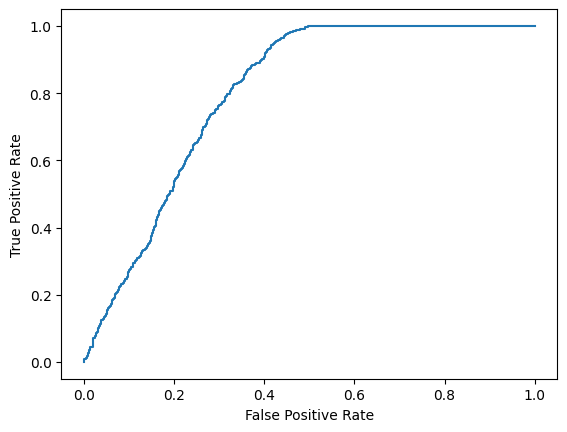

In [74]:
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# Conclusions

### Data Cleaning

* The 'Unnamed: 0' column was dropped as it offered no new information to the dataset and was not relevant.

* The columns were found to contain no null entries and all be the correct data type after initial checks.

* The columns were also found to have no oddities in their descriptive statistics after preliminary checks (no potential outliers found)

  * Note that outliers were found after feature engineering, their handling will be described there.

### Data Exploration

* This section began with a univariate analysis which was then followed by the comparison of each column with the target column, 'Churn'

* It is worth noting that data imbalances among age and location were found. With some ages having lower counts than others, and significantly many more customers were located in CAN and USA than AUS and Great Britain. This was noted because some models can have difficulty dealing with imbalanced data, furthermore, this means that the accuracy performance metric for models may not be useful.

  * Also an imbalance among the amount of customers who have churned vs not churned, further invalidating the accuracy performance metric of models.

* Nothing of interest was found among the monthly columns, many of them appeared to have similar distributions.

  * Above these cells have had their outputs collapsed to conserve space.

This concludes the univariate analysis, the bi-variate analysis begins here.

* It was noted that certain ages did churn less than others, with ages 64 and 65 not churning at all. However, no discernable relationship was present, it seemed random. Because of this it was conluded that age does not have a significant impact on churn, and was not included as an input feature for the models.

* It was found that customers who have churned resided only in the USA and Canada, no customers located in Australia or Great Britain churned. This could be due to the fact that the majority of customers are located in North America within the data set however it is a notable relationship nonetheless. It was concluded that location does have an impact on churn and it was included as an input feature for the models.

* It was found that customers who used Android devices accounted for a much larger portion of churned customers than those who used iOS devices. Thus it was concluded that device type does have an impact on churn and will be included in as an input to the models.

* It was found that the monthly values for the customers did have some very minute trends. But these trends were sparsely distributed. It was concluded that the monthly data is too spread out and inconsistent to be used as an input feature for the models or have an impact on churn. However, there is potential, see next section.

### Feature Engineering

* Within a data pipeline, all numerical columns had a min-max scaling applied to them and all categorical columns had a one hot encoding applued to them.

* The monthly data was aggregated into quarterly average for each customer. This reduced the granularity of the data and allowed for more meaningful trends to be extracted. It was found that the support calls from all quarters did have an effect on churn and the amount of items bought from quarters 3 and 4 had an impact on churn as well.

### Hypothesis / Prediction

* Based on the above analysis, it is predicted that the following features have an impact on whether or not a customer will churn: Location, Device, Support calls from all quarters, amount of items bought in Q3 and Q4.

### Model Selection

* It was found that the SVM classifier had the highest f1 score against all tested models and was selected.

### Model Tuning

* I will optimize for recall. In this case it is most important to be able to correctly predict churn, thus it paramount that the number of false negatives are reduced. Here a false negative would represent a customer who has churned, but was predicted to not have churned, the goal of the model is to predict when a customer will churn.   

* Optimizing for precision would ultimately reduce the number of false positives. In this case a false positive would be a customer who was predicted to churn, but ultimately did not. This is not as severse as failing to predict a churn, thus precision will not be optimized for.   

* Say we offer a promo to customers we expect to churn, it is much better to offer the promo by accident to a customer who will not churn (false positive), than it is to not get the promo to a customer who will churn (false negative).

### Future Model Use Case

* In the future this model can be used to predict when a customer will churn. Given some inputs about the customer and their transactions over the last 12 months, and demogrpahic information about the customer themselves.

* A potential use case would be that if the model does predict that a customer will churn, then perhaps the marketing team can offer a promo to that customer to prevent them from churning.

* And as for what has caused this current month to have high churn, given that customers primarily using Android devices in North America churned, and had more support calls. It is highly possible that there was a bug/glitch in the app that affected android users in North America in the months leading up to this, indicated by the higher support calls, and it caused many customers to stop using the app.